<table>
<td height="150px">
<img src='https://stergioc.github.io/assets/img/logos.png' />
</td>
</table>

## Section 1. Training a CNN 
The objective of this notebook is creating a algorithm to detect tumorous cells. The CNN model will classyfing images as either healthy. The CNN will be trained on a dataset of [histopathology patches](https://en.wikipedia.org/wiki/Histopathology). This data corresponds to digitized microscopic analysis of tumor tissue, which has been divided into patches. The objective is to classify the patches into the ones containing tumor tissue, and ones not containing any tumor tissue. We will use the [PCAM dataset](https://github.com/basveeling/pcam) which consists of 96x96 pixel patches. We will only use the validation set (which contains 32768 patches and which should take about 0.8 GB of storage) in order to make the training faster.

In [1]:
import h5py
import random
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.utils import download_file_from_google_drive, _decompress
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchnet as tnt
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
np.int = int


In [2]:
import torch
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device      
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

PyTorch version: 2.1.2
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


1.1. Download the dataset which is stored in a `.h5` file.
The images can be download from [here](https://drive.google.com/uc?export=download&id=1hgshYGWK8V-eGRy8LToWJJgDU_rXWVJ3), and the labels from [here](https://drive.google.com/uc?export=download&id=1bH8ZRbhSVAhScTS0p9-ZzGnX91cHT3uO). Please then unzip the files and write the paths below. **[1 pt]**

In [3]:
# from torchvision.datasets.utils import download_file_from_google_drive, _decompress

# # You can run the following cell to download the files on colab
# base_folder = "./"
# archive_name = "camelyonpatch_level_2_split_valid_x.h5.gz"
# download_file_from_google_drive("1hgshYGWK8V-eGRy8LToWJJgDU_rXWVJ3", base_folder, filename=archive_name, md5="d5b63470df7cfa627aeec8b9dc0c066e")
# _decompress(base_folder + archive_name)

# archive_name = "camelyonpatch_level_2_split_valid_y.h5.gz"
# download_file_from_google_drive("1bH8ZRbhSVAhScTS0p9-ZzGnX91cHT3uO", base_folder, filename=archive_name, md5="2b85f58b927af9964a4c15b8f7e8f179")
# _decompress(base_folder + archive_name)

In [4]:
IMAGES_PATH = "camelyonpatch_level_2_split_valid_x.h5"
LABELS_PATH = "camelyonpatch_level_2_split_valid_y.h5"

In [5]:
images = np.array(h5py.File(IMAGES_PATH)['x'])
labels = np.array([y.item() for y in h5py.File(LABELS_PATH)['y']])

### Dataset preparation
1.2. Now that we have the data, we will want to split it into a training and a validation set. For this, we will write a function which takes in as input the size of the dataset, and which will return the indices of the training set and the indices of the validation set. 

In [6]:
random.seed(0)

In [7]:
def get_split_indices(dataset_length, train_ratio=0.7, seed=0):
    """
    Function which splits the data into training and validation sets.
    arguments:
        dataset_length [int]: number of elements in the dataset
        train_ratio [float]: ratio of the dataset in the training set
        seed [int]: random seed for reproducibility
    returns:
        train_indices [list]: list of indices in the training set (of size dataset_length*train_ratio)
        val_indices [list]: list of indices in the validation set (of size dataset_length*(1-train_ratio))
    """
    # Set the random seed for reproducibility
    np.random.seed(seed)

    # Generate a shuffled array of indices
    indices = np.arange(dataset_length)
    np.random.shuffle(indices)

    # Calculate the split index
    split_index = int(dataset_length * train_ratio)

    # Split the indices into training and validation sets
    train_indices = indices[:split_index].tolist()
    val_indices = indices[split_index:].tolist()

    return train_indices, val_indices


In [8]:
train_indices, val_indices = get_split_indices(len(labels))

In [9]:
# from torch.utils.data import Dataset
import numpy as np

class PCAMDataset(Dataset):
    def __init__(self, data, labels, train):
        """
        Dataset class for the PCAM dataset.
        arguments:
            data [numpy.array]: all RGB 96x96 images
            labels [numpy.array]: corresponding labels
            train [bool]: whether the dataset is training or validation
        """
        super(PCAMDataset, self).__init__()
        self.data = data
        self.labels = labels
        self.train = train

        if self.train:
            self.augmentation = transforms.Compose([transforms.ToTensor(), transforms.Normalize(np.mean(self.data, axis=(0, 1, 2)), np.std(self.data, axis=(0, 1, 2))), transforms.RandomRotation((0,180)), transforms.Resize((160, 200))])
        else:
            self.augmentation = transforms.Compose([transforms.ToTensor(), transforms.Normalize(np.mean(self.data, axis=(0, 1, 2)), np.std(self.data, axis=(0, 1, 2))), transforms.Resize((160, 200))])


    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        return image, label

In [10]:
BATCH_SIZE = 64

In [11]:
train_dataset = PCAMDataset(images[train_indices], labels[train_indices], train=True)
val_dataset = PCAMDataset(images[val_indices], labels[val_indices], train=False)
train_dataloader = DataLoader(train_dataset, batch_size=int(BATCH_SIZE), shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=int(BATCH_SIZE), shuffle=False)

### Visual check
1.3 Let's display a random sample of images that have a label of 0 (not containing
any tumor tissue) and 1 (containing tumor tissue).

Let's also try to identify the features in a particular image which cause it to be classified as having tumor tissue or not.

In [12]:
def display_random_samples(dataset, num_samples=5):
    """
    Display a random sample of images with labels 0 and 1, with increased overall plot size.
    arguments:
        dataset: instance of PCAMDataset
        num_samples (int): number of samples to display for each label
    """
    # Separate indices by label
    indices_0 = [i for i, label in enumerate(dataset.labels) if label == 0]
    indices_1 = [i for i, label in enumerate(dataset.labels) if label == 1]

    # Randomly select samples
    random_indices_0 = np.random.choice(indices_0, num_samples, replace=False)
    random_indices_1 = np.random.choice(indices_1, num_samples, replace=False)

    # Setup plot with increased size
    # Adjust the width and height here to increase the size of the plot
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 3, 6))
    fig.suptitle('Random Samples of tumor images', verticalalignment='top', y=1.0)

    # Adjust spacing
    plt.subplots_adjust(hspace=0.3, top=0.85)

    # Display images with label 0
    for ax, idx in zip(axes[0], random_indices_0):
        image, label = dataset[idx]
        ax.imshow(image)
        # ax.set_title(f"Label: {label}")
        ax.set_title(f"Healthy")
        ax.axis('off')

    # Display images with label 1
    for ax, idx in zip(axes[1], random_indices_1):
        image, label = dataset[idx]
        ax.imshow(image)
        # ax.set_title(f"Label: {label}")
        ax.set_title(f"Tumor")
        ax.axis('off')

    plt.show()



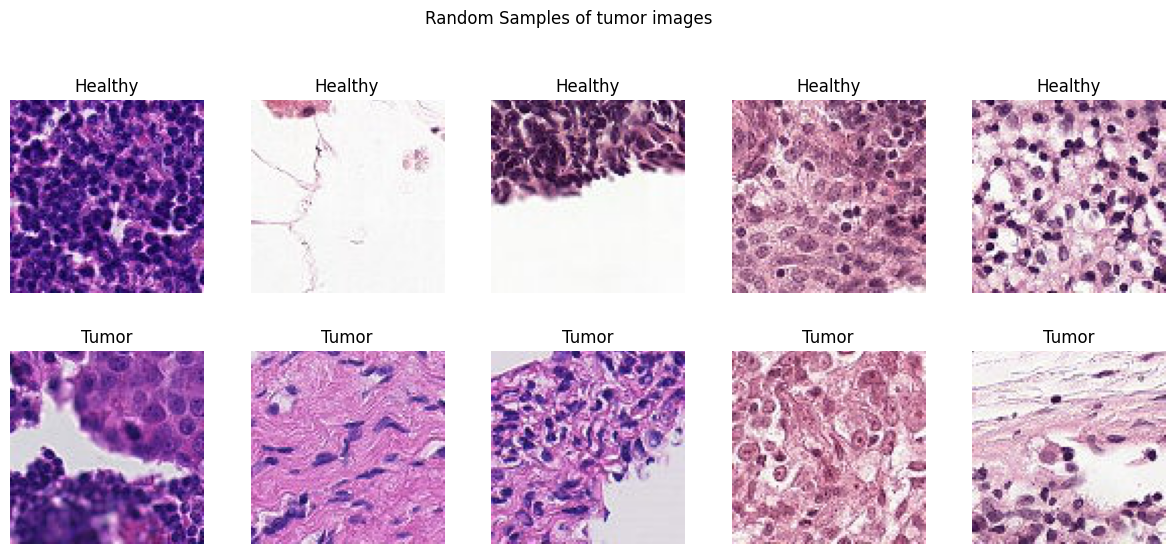

In [13]:
display_random_samples(train_dataset)

From the random sample of images above, tumor cells seems to have inner dots, while healthy cells do not.

In [14]:
def guess_the_label(dataset):
    """
    Displays a random image from the dataset, asks the user to guess the label, informs whether the guess was correct,
    and asks if the user wants to try again.
    arguments:
        dataset: instance of PCAMDataset
    """
    correct_guesses = 0
    total_guesses = 0

    while True:
        # Randomly select an image
        idx = np.random.randint(len(dataset))
        image, true_label = dataset[idx]

        # Display the image
        plt.imshow(image)
        plt.title("Guess the label of this image (0 = healthy or 1 = tumorous)")
        plt.axis('off')
        plt.show()

        # Ask for user's guess
        user_guess = input("Enter your guess (0 = healthy or 1 = tumorous): ")

        # Check if the input is valid
        if user_guess not in ['0', '1']:
            print("Invalid input. Please enter 0 or 1.")
            continue

        # Convert the user's guess to an integer
        user_guess = int(user_guess)
        total_guesses += 1

        # Inform the user if they were right or wrong
        if user_guess == true_label:
            print("Correct!")
            correct_guesses += 1
        else:
            print(f"Wrong. The correct label was {true_label}.")

        # Ask the user if they want to try another guess
        try_again = input("Do you want to try another guess? (yes or no): ").lower()
        if try_again != 'yes':
            break

    # Calculate and display the ratio of correct guesses
    if total_guesses > 0:
        accuracy = correct_guesses / total_guesses
        print(f"You guessed correctly {correct_guesses} out of {total_guesses} times. Accuracy: {accuracy:.2f}")
    else:
        print("No guesses were made.")


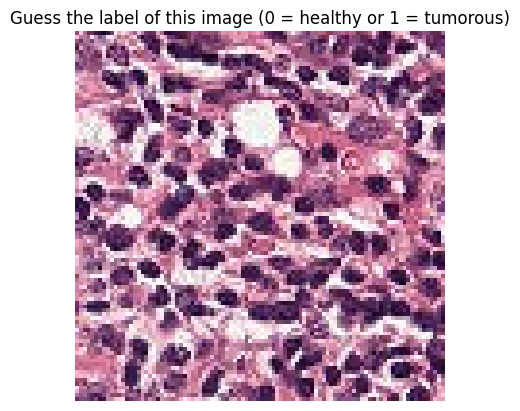

Wrong. The correct label was 0.


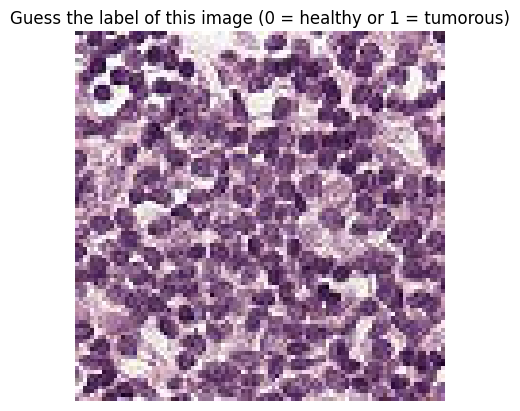

Wrong. The correct label was 0.


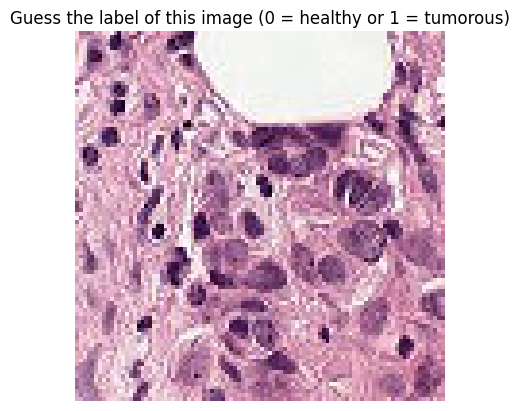

Wrong. The correct label was 1.


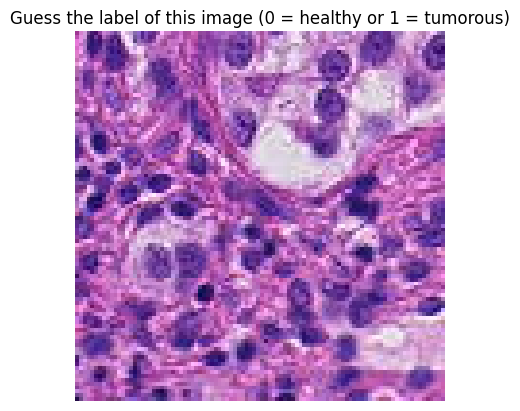

Correct!


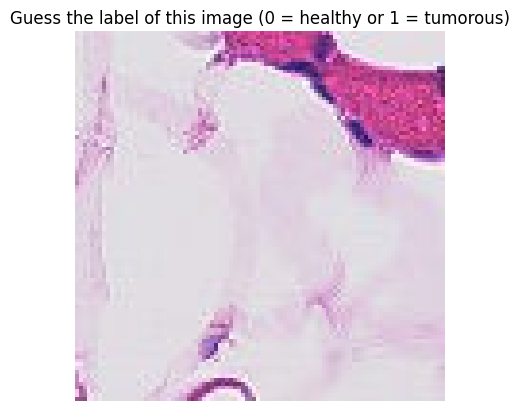

Correct!
You guessed correctly 2 out of 5 times. Accuracy: 0.40


In [35]:
guess_the_label(train_dataset)

### Label distribution
1.4. Let's now plot the distribution of class labels in the training and validation datasets, to see how well the classes are balanced.

In [16]:
def plot_label_distribution(train_labels, val_labels):
    """
    Plots the distribution of class labels in training and validation datasets with adjusted layout to prevent overlap.
    arguments:
        train_labels: Labels of the training dataset
        val_labels: Labels of the validation dataset
    """
    # Count the occurrences of each label in the training and validation datasets
    train_counts = [np.sum(train_labels == i) for i in np.unique(train_labels)]
    val_counts = [np.sum(val_labels == i) for i in np.unique(val_labels)]

    # Set up the bar plot
    labels = ['Label 0', 'Label 1']
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    # Create a larger figure to give more space
    fig, ax = plt.subplots(figsize=(8, 6))
    rects1 = ax.bar(x - width/2, train_counts, width, label='Train')
    rects2 = ax.bar(x + width/2, val_counts, width, label='Validation')

    # Add some text for labels, title, and custom x-axis tick labels
    ax.set_ylabel('Counts')
    ax.set_title('Distribution of class labels in Training and Validation datasets')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc='upper right')  # Move the legend to the upper right to prevent overlap

    # Function to auto-adjust the labels
    def auto_label(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    auto_label(rects1)
    auto_label(rects2)

    # Automatically adjust subplot params to give specified padding
    plt.tight_layout()
    plt.show()

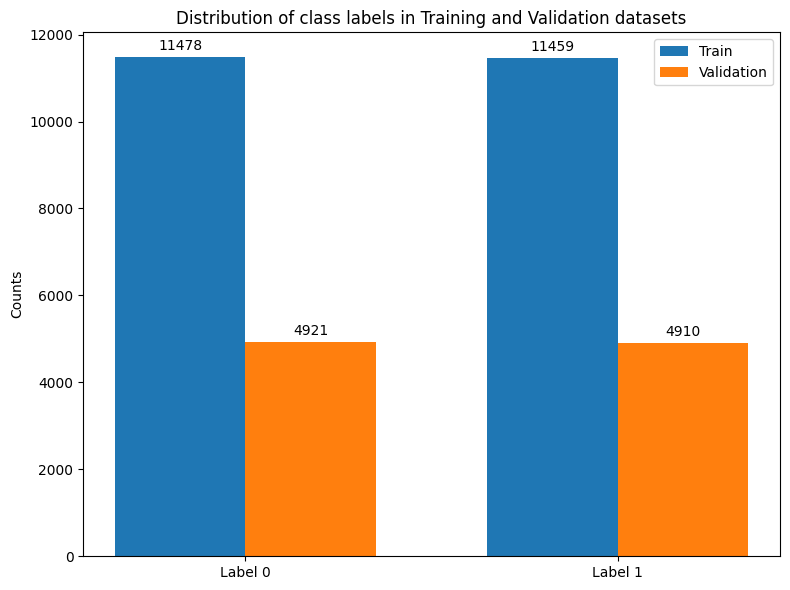

In [17]:
plot_label_distribution(train_dataset.labels, val_dataset.labels)

### Model Architecture

Let's now define our model class.

In [18]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
torch.manual_seed(42)

class ConvNet(nn.Module):
    def __init__(self, num_layers, initial_channels=32, num_classes=2, input_dim=96, drop_prob = 0.2):
        super(ConvNet, self).__init__()

        self.layers = nn.ModuleList()
        in_channels = 3  # Input channels for the first layer

        for i in range(num_layers):
            self.layers.append(nn.Conv2d(in_channels=in_channels, out_channels=initial_channels, kernel_size=3, padding=1))
            # Apply He initialization to the convolutional layers
            init.kaiming_normal_(self.layers[-1].weight, mode='fan_out', nonlinearity='relu')
            # Calculate normalized_shape based on the current number of output channels
            normalized_shape = [initial_channels, input_dim, input_dim]
            self.layers.append(nn.LayerNorm(normalized_shape))
            self.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = initial_channels
            initial_channels *= 2  # Double the channels for the next layer
            input_dim = input_dim // 2  # Update input height after max-pooling
            if i > 0:
                self.layers.append(nn.Dropout(p=drop_prob))
                drop_prob *= 1.5 

        # Calculate the correct number of input features for the linear layer
        # based on the final output shape
        linear_input_features = (initial_channels // 2) * (input_dim ** 2)
        self.fc1 = nn.Linear(in_features=linear_input_features, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        for layer in self.layers:
            x = layer(F.relu(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



The code above defines a modular convolutional neural network. The class takes several inputs that specify the structure of the neural network:
- **num_layers**: depth of the neural network (i.e., the number of hidden layers)
- **initial_channels**:  number of filters applied in the first layer
- **num_classes**: number of classes that the model will predict
- **input_dim**: input dimensions (height and width) of the images processed by the model
- **drop_prob**: probability of the dropout layer, to prevent overfitting

The number of kernels are doubled between each convolutional layer. Moreover, each convolutional layer is initialiazed applying He initialization (to prevent exploding/vanishing gradients) and is then normalized. At this point, a pooling layer is used to reduce the size of the input image in half. Finally, it applies a dropout layer to every layer but the first, and the dropout probability increases by 50% at every layer (to prevent overfitting).

Lastly, two fully connected layers are created to make the final prediction. These layers interpret the features extracted from the image for classification. The first fully connected layer compresses the data from the flattened state to 512, effectively condensing the features for easier classification. The final fully connected layer further narrows down the features to match the number of classes, which, in this model, is two for binary classification.

### Another modeling approach: ResNet

Below there is additional code to create modular ResNet models. Such models are meant to prevent overfitting using skip connections. For the optimization part, I ran different hyper parameter tunings, depending on the type of model (simpler CNN vs ResNet)

In [19]:
import torch.nn as nn
import torch.nn.functional as F

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):

    expansion: int = 4

    def __init__(self, inplanes: int, planes: int, stride = 1, downsample = None,
                 groups = 1, base_width = 64, dilation = 1, norm_layer = None,):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=2, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 32, layers[0])
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 256, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    forward = _forward

def resnet18(**kwargs):
    return ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)

### Importance of Recall
Given that we are dealing with medical data, and more precisely with predicting tumurous cells, it is very important to focus on the model validation recall. In the medical field, the primary concern is patient safety. Missing a cancerous cell (false negative) can have severe consequences for the patient, as it may lead to a delayed diagnosis and treatment. Maximizing recall ensures that as many true positive cases (cancerous cells) are correctly identified, reducing the chances of missing critical cases. For these reasons, for each epoch we will plot the loss, accuray as well as the recall.

In [20]:
def plot_metrics(epochs, 
                 total_train_losses, 
                 total_val_losses, 
                 total_train_accuracies, 
                 total_val_accuracies, 
                 total_train_recalls, 
                 total_val_recalls, 
                 plt_loss=True, 
                 plt_acc=True, 
                 plt_recall=True):
        
    # Plotting the metrics
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(18, 5))  # Increase the width to accommodate three subplots

    if plt_loss:
        # Plot training losses in red and validation losses in blue with grid lines
        plt.subplot(1, 3, 1)
        plt.plot(epochs_range, total_train_losses, label='Training Loss', marker='o', color='red')
        plt.plot(epochs_range, total_val_losses, label='Validation Loss', marker='o', color='blue')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

    if plt_acc:
        # Plot training accuracies in red and validation accuracies in blue with grid lines
        plt.subplot(1, 3, 2)
        plt.plot(epochs_range, total_train_accuracies, label='Training Accuracy', marker='o', color='red')
        plt.plot(epochs_range, total_val_accuracies, label='Validation Accuracy', marker='o', color='blue')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

    if plt_recall:
        # Plot training recalls in red and validation recalls in blue with grid lines
        plt.subplot(1, 3, 3)
        plt.plot(epochs_range, total_train_recalls, label='Training Recall', marker='o', color='red')
        plt.plot(epochs_range, total_val_recalls, label='Validation Recall', marker='o', color='blue')
        plt.title('Training and Validation Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


In [21]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix  # Import confusion_matrix function from sklearn.metrics
torch.manual_seed(42)
# Accuracy = (TP+TN)/(TP+TN+FP+FN) # How the models performs accross all classes
def accuracy(preds, labels):
    return (labels == preds).sum() / len(labels) # Argmax of logits is the argmax of the predictions (the softmax of the logits)

def training_loop(model, 
                  epochs, 
                  train_dataloader, 
                  val_dataloader, 
                  optim, 
                  criterion, 
                  device, 
                  plot_metrs=False, 
                  plot_LOSS=True, 
                  plot_ACC=True, 
                  plot_REC=True, 
                  restore_best_weights_loss=True, 
                  restore_best_weights_recall=False, 
                  return_model=False):
    total_train_losses = []
    total_val_losses = []
    total_train_accuracies = []
    total_val_accuracies = []
    total_train_recalls = []  # Added to store recall values during training
    total_val_recalls = []    # Added to store recall values during validation

    best_val_loss = float('inf')
    best_val_rec = float('inf')
    best_epoch_metrics = None
    best_model_weights = None

    num_classes = 2

    for epoch in range(1, epochs + 1):
        print(f'epoch: {epoch}')
        ## TRAINING ##
        model.train()
        train_losses = []
        trn_lbl = torch.Tensor([]).to(device)
        trn_preds = torch.Tensor([]).to(device)

        # Wrap training loop with tqdm
        for i, batch in enumerate(tqdm(train_dataloader)):
            img_batch, lbl_batch = batch
            img_batch = (img_batch.float() / 255.0).permute(0, 3, 1, 2).to(device)
            lbl_batch = lbl_batch.to(device)

            optim.zero_grad()
            logits = model(img_batch)
            loss = criterion(logits, lbl_batch)
            loss.backward()
            optim.step()

            preds = logits.argmax(1)
            trn_preds = torch.cat((trn_preds, preds))
            trn_lbl = torch.cat((trn_lbl, lbl_batch))

            train_losses.append(loss.item())

        train_acc = accuracy(trn_preds.cpu(), trn_lbl.cpu()).item()
        train_loss_mean = np.mean(train_losses)
        total_train_losses.append(train_loss_mean)
        total_train_accuracies.append(train_acc)

        # Calculate and store the recall for training data
        # Recall for class 1: val_cm[1, 1] corresponds to the number of true positives (TP), 
        # val_cm[1, 0] + val_cm[1, 1] corresponds to the sum of true positives (TP) and false negatives (FN). 
        # Therefore, val_recalls calculates the recall for the validation set, specifically for the positive class (class 1).
        train_cm = confusion_matrix(trn_lbl.cpu(), trn_preds.cpu())
        train_recalls = train_cm[1, 1] / (train_cm[1, 0] + train_cm[1, 1])  # Recall for class 1
        total_train_recalls.append(train_recalls)

        ## VALIDATION ##
        model.eval()
        val_losses = []
        val_lbl = torch.Tensor([]).to(device)
        val_preds = torch.Tensor([]).to(device)

        # Wrap validation loop with tqdm
        with torch.no_grad():
            for i, batch in enumerate(tqdm(val_dataloader)):
                img_batch, lbl_batch = batch
                img_batch = (img_batch.float() / 255.0).permute(0, 3, 1, 2).to(device)
                lbl_batch = lbl_batch.to(device)

                logits = model(img_batch)
                loss = criterion(logits, lbl_batch)

                preds = logits.argmax(1)
                val_preds = torch.cat((val_preds, preds))
                val_lbl = torch.cat((val_lbl, lbl_batch))

                val_losses.append(loss.item())

            val_acc = accuracy(val_preds.cpu(), val_lbl.cpu()).item()
            val_loss_mean = np.mean(val_losses)
            total_val_losses.append(val_loss_mean)
            total_val_accuracies.append(val_acc)

            # Calculate and store the recall for validation data
            val_cm = confusion_matrix(val_lbl.cpu(), val_preds.cpu())
            val_recalls = val_cm[1, 1] / (val_cm[1, 0] + val_cm[1, 1])  # Recall for class 1
            total_val_recalls.append(val_recalls)

        # Check if current validation loss is the best and save model weights
        if restore_best_weights_loss:
            restore_best_weights_recall = False
            if val_loss_mean < best_val_loss:
                best_val_loss = val_loss_mean
                best_epoch_metrics = [train_loss_mean, val_loss_mean, train_acc, val_acc, train_recalls, val_recalls]
                best_model_weights = model.state_dict()
        
        if restore_best_weights_recall:
            if val_recalls > best_val_rec:
                best_val_loss = val_loss_mean
                best_epoch_metrics = [train_loss_mean, val_loss_mean, train_acc, val_acc, train_recalls, val_recalls]
                best_model_weights = model.state_dict()

        # Print training and validation metrics including recall
        print(f'Training Loss: {train_loss_mean:.4f}, Training Accuracy: {train_acc:.4f}, Training Recall for class 1 (tumor): {train_recalls:.4f}')
        print(f'Validation Loss: {val_loss_mean:.4f}, Validation Accuracy: {val_acc:.4f}, Validation Recall for class 1 (tumor): {val_recalls:.4f}')

    # Restore the best model weights if required
    if restore_best_weights_loss and best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    if plot_metrs:
        plot_metrics(epochs, 
                    total_train_losses, 
                    total_val_losses, 
                    total_train_accuracies, 
                    total_val_accuracies, 
                    total_train_recalls, 
                    total_val_recalls, 
                    plt_loss = plot_LOSS, 
                    plt_acc = plot_ACC, 
                    plt_recall = plot_REC)

    if restore_best_weights_loss and best_epoch_metrics:
        best_train_loss = best_epoch_metrics[0]
        best_val_loss = best_epoch_metrics[1]
        best_train_accuracy = best_epoch_metrics[2]
        best_val_accuracy = best_epoch_metrics[3]
        if return_model:
            return best_train_loss, best_val_loss, best_train_accuracy, best_val_accuracy, val_recalls, model
        else:
            return best_train_loss, best_val_loss, best_train_accuracy, best_val_accuracy, val_recalls
    else:
        final_train_loss = total_train_losses[-1] if total_train_losses else None
        final_val_loss = total_val_losses[-1] if total_val_losses else None
        final_train_accuracy = total_train_accuracies[-1] if total_train_accuracies else None
        final_val_accuracy = total_val_accuracies[-1] if total_val_accuracies else None
        if return_model:
            return final_train_loss, final_val_loss, final_train_accuracy, final_val_accuracy, val_recalls, model
        else:
            return final_train_loss, final_val_loss, final_train_accuracy, final_val_accuracy, val_recalls


epoch: 1


  0%|          | 0/359 [00:00<?, ?it/s]

100%|██████████| 154/154 [00:03<00:00, 47.84it/s]


Training Loss: 0.7476, Training Accuracy: 0.6868, Training Recall for class 1 (tumor): 0.7186
Validation Loss: 0.4231, Validation Accuracy: 0.8070, Validation Recall for class 1 (tumor): 0.8969
epoch: 2


100%|██████████| 154/154 [00:02<00:00, 67.11it/s]


Training Loss: 0.4214, Training Accuracy: 0.8052, Training Recall for class 1 (tumor): 0.8404
Validation Loss: 0.4014, Validation Accuracy: 0.8133, Validation Recall for class 1 (tumor): 0.8464
epoch: 3


100%|██████████| 154/154 [00:02<00:00, 71.98it/s]


Training Loss: 0.3883, Training Accuracy: 0.8253, Training Recall for class 1 (tumor): 0.8683
Validation Loss: 0.4343, Validation Accuracy: 0.7998, Validation Recall for class 1 (tumor): 0.9073
epoch: 4


100%|██████████| 154/154 [00:02<00:00, 76.00it/s]


Training Loss: 0.3638, Training Accuracy: 0.8387, Training Recall for class 1 (tumor): 0.8863
Validation Loss: 0.4137, Validation Accuracy: 0.8235, Validation Recall for class 1 (tumor): 0.9695
epoch: 5


100%|██████████| 154/154 [00:01<00:00, 78.48it/s]


Training Loss: 0.3263, Training Accuracy: 0.8618, Training Recall for class 1 (tumor): 0.9023
Validation Loss: 0.3380, Validation Accuracy: 0.8526, Validation Recall for class 1 (tumor): 0.8509
epoch: 6


100%|██████████| 154/154 [00:01<00:00, 80.03it/s]


Training Loss: 0.2822, Training Accuracy: 0.8843, Training Recall for class 1 (tumor): 0.9174
Validation Loss: 0.2973, Validation Accuracy: 0.8753, Validation Recall for class 1 (tumor): 0.8699


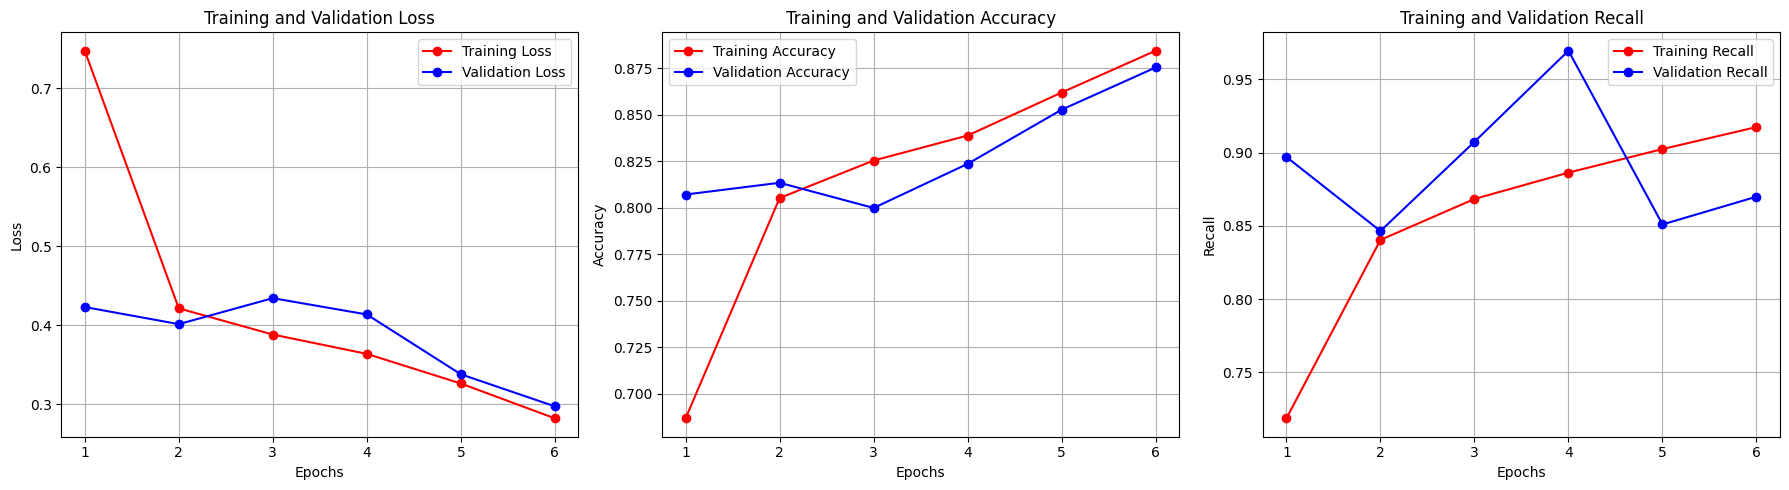

In [22]:
num_layers = 3  
CNN1 = ConvNet(num_layers=num_layers, drop_prob=0.03, initial_channels = 48).to(device)
# print(model)
lr = 0.001
num_epochs = 6
optimizer = torch.optim.Adam(CNN1.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

best_train_loss, best_val_loss, best_train_accuracy, best_val_accuracy, val_recall = training_loop(CNN1, num_epochs, train_dataloader, val_dataloader, optimizer, criterion, device, plot_metrs = True)

epoch: 1


100%|██████████| 154/154 [00:01<00:00, 99.37it/s] 


Training Loss: 0.3493, Training Accuracy: 0.8496, Training Recall for class 1 (tumor): 0.8812
Validation Loss: 0.3735, Validation Accuracy: 0.8377, Validation Recall for class 1 (tumor): 0.9762
epoch: 2


100%|██████████| 154/154 [00:01<00:00, 117.97it/s]


Training Loss: 0.2400, Training Accuracy: 0.9019, Training Recall for class 1 (tumor): 0.9243
Validation Loss: 0.2844, Validation Accuracy: 0.8789, Validation Recall for class 1 (tumor): 0.8301
epoch: 3


100%|██████████| 154/154 [00:01<00:00, 115.52it/s]


Training Loss: 0.1882, Training Accuracy: 0.9269, Training Recall for class 1 (tumor): 0.9409
Validation Loss: 0.2276, Validation Accuracy: 0.9084, Validation Recall for class 1 (tumor): 0.9330
epoch: 4


100%|██████████| 154/154 [00:01<00:00, 133.75it/s]


Training Loss: 0.1549, Training Accuracy: 0.9409, Training Recall for class 1 (tumor): 0.9509
Validation Loss: 0.2987, Validation Accuracy: 0.8855, Validation Recall for class 1 (tumor): 0.9200
epoch: 5


100%|██████████| 154/154 [00:01<00:00, 121.76it/s]


Training Loss: 0.1299, Training Accuracy: 0.9508, Training Recall for class 1 (tumor): 0.9601
Validation Loss: 1.2903, Validation Accuracy: 0.6552, Validation Recall for class 1 (tumor): 0.3161
epoch: 6


100%|██████████| 154/154 [00:01<00:00, 118.22it/s]


Training Loss: 0.1105, Training Accuracy: 0.9573, Training Recall for class 1 (tumor): 0.9628
Validation Loss: 0.3277, Validation Accuracy: 0.8980, Validation Recall for class 1 (tumor): 0.9703
epoch: 7


100%|██████████| 154/154 [00:01<00:00, 122.26it/s]


Training Loss: 0.0982, Training Accuracy: 0.9622, Training Recall for class 1 (tumor): 0.9661
Validation Loss: 0.3469, Validation Accuracy: 0.8735, Validation Recall for class 1 (tumor): 0.9291
epoch: 8


100%|██████████| 154/154 [00:01<00:00, 131.30it/s]


Training Loss: 0.0746, Training Accuracy: 0.9714, Training Recall for class 1 (tumor): 0.9750
Validation Loss: 0.4249, Validation Accuracy: 0.8899, Validation Recall for class 1 (tumor): 0.9825
epoch: 9


100%|██████████| 154/154 [00:01<00:00, 127.46it/s]


Training Loss: 0.0668, Training Accuracy: 0.9749, Training Recall for class 1 (tumor): 0.9759
Validation Loss: 0.8546, Validation Accuracy: 0.7660, Validation Recall for class 1 (tumor): 0.5501
epoch: 10


100%|██████████| 154/154 [00:01<00:00, 127.88it/s]


Training Loss: 0.0552, Training Accuracy: 0.9798, Training Recall for class 1 (tumor): 0.9812
Validation Loss: 0.7152, Validation Accuracy: 0.8520, Validation Recall for class 1 (tumor): 0.9923


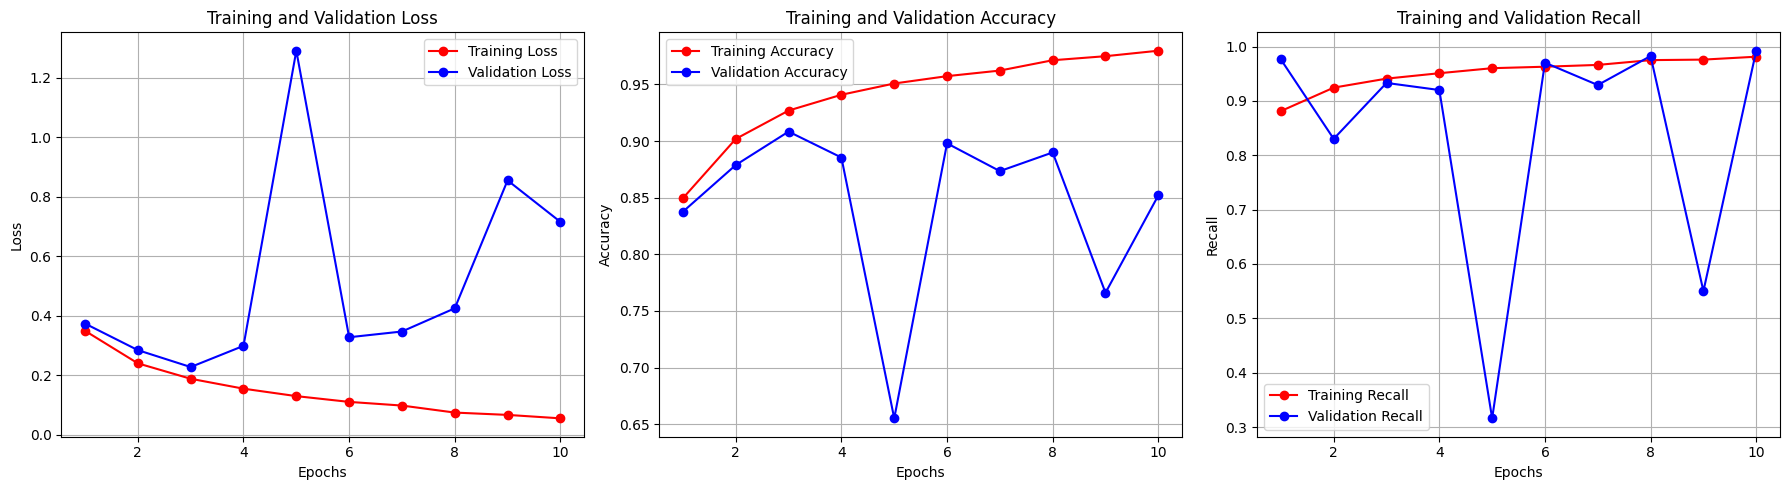

In [23]:
net_args = {
    "block": BasicBlock,
    "layers": [2, 2, 2, 2],
    "num_classes": 2,} 

ResNET18 = ResNet(**net_args).to(device)
# print(model)
num_epochs = 10
optimizer2 = torch.optim.AdamW(ResNET18.parameters(), lr=0.001)
_, _, _, _, _ = training_loop(ResNET18, num_epochs, train_dataloader, val_dataloader, optimizer2, criterion, device, plot_metrs = True)

2.8. Validate your model, show that it is not overfitting. Justify your choice of metric. Answer this either with code or Markdown (or both). **[3 pts]**

`ANSWER HERE`

Despite the ResNet model seems to achieve a higher accuracy, its loss functions does not show a smooth downward trend, which may be caused by overfitting. For this reason, we will use the simpler CNN model. Later in the notebook we will see that hyperparameter tuning will fix the overfitting issue of the ResNet model.

epoch: 1


100%|██████████| 154/154 [00:01<00:00, 83.08it/s]


Training Loss: 0.7865, Training Accuracy: 0.6653, Training Recall for class 1 (tumor): 0.6725
Validation Loss: 0.5232, Validation Accuracy: 0.7551, Validation Recall for class 1 (tumor): 0.9629
epoch: 2


100%|██████████| 154/154 [00:01<00:00, 82.10it/s]


Training Loss: 0.4378, Training Accuracy: 0.7930, Training Recall for class 1 (tumor): 0.8424
Validation Loss: 0.4689, Validation Accuracy: 0.7870, Validation Recall for class 1 (tumor): 0.9695
epoch: 3


100%|██████████| 154/154 [00:01<00:00, 82.07it/s]


Training Loss: 0.3985, Training Accuracy: 0.8157, Training Recall for class 1 (tumor): 0.8715
Validation Loss: 0.3769, Validation Accuracy: 0.8326, Validation Recall for class 1 (tumor): 0.9171
epoch: 4


100%|██████████| 154/154 [00:01<00:00, 81.99it/s]


Training Loss: 0.3699, Training Accuracy: 0.8341, Training Recall for class 1 (tumor): 0.8876
Validation Loss: 0.3764, Validation Accuracy: 0.8318, Validation Recall for class 1 (tumor): 0.8872
epoch: 5


100%|██████████| 154/154 [00:01<00:00, 81.82it/s]


Training Loss: 0.3399, Training Accuracy: 0.8533, Training Recall for class 1 (tumor): 0.9078
Validation Loss: 0.3787, Validation Accuracy: 0.8418, Validation Recall for class 1 (tumor): 0.9426
epoch: 6


100%|██████████| 154/154 [00:01<00:00, 81.86it/s]


Training Loss: 0.3025, Training Accuracy: 0.8734, Training Recall for class 1 (tumor): 0.9178
Validation Loss: 0.3447, Validation Accuracy: 0.8545, Validation Recall for class 1 (tumor): 0.8992
epoch: 7


100%|██████████| 154/154 [00:01<00:00, 81.67it/s]


Training Loss: 0.2734, Training Accuracy: 0.8873, Training Recall for class 1 (tumor): 0.9221
Validation Loss: 0.3594, Validation Accuracy: 0.8511, Validation Recall for class 1 (tumor): 0.9012
epoch: 8


100%|██████████| 154/154 [00:01<00:00, 82.09it/s]


Training Loss: 0.2254, Training Accuracy: 0.9077, Training Recall for class 1 (tumor): 0.9320
Validation Loss: 0.3788, Validation Accuracy: 0.8647, Validation Recall for class 1 (tumor): 0.9151


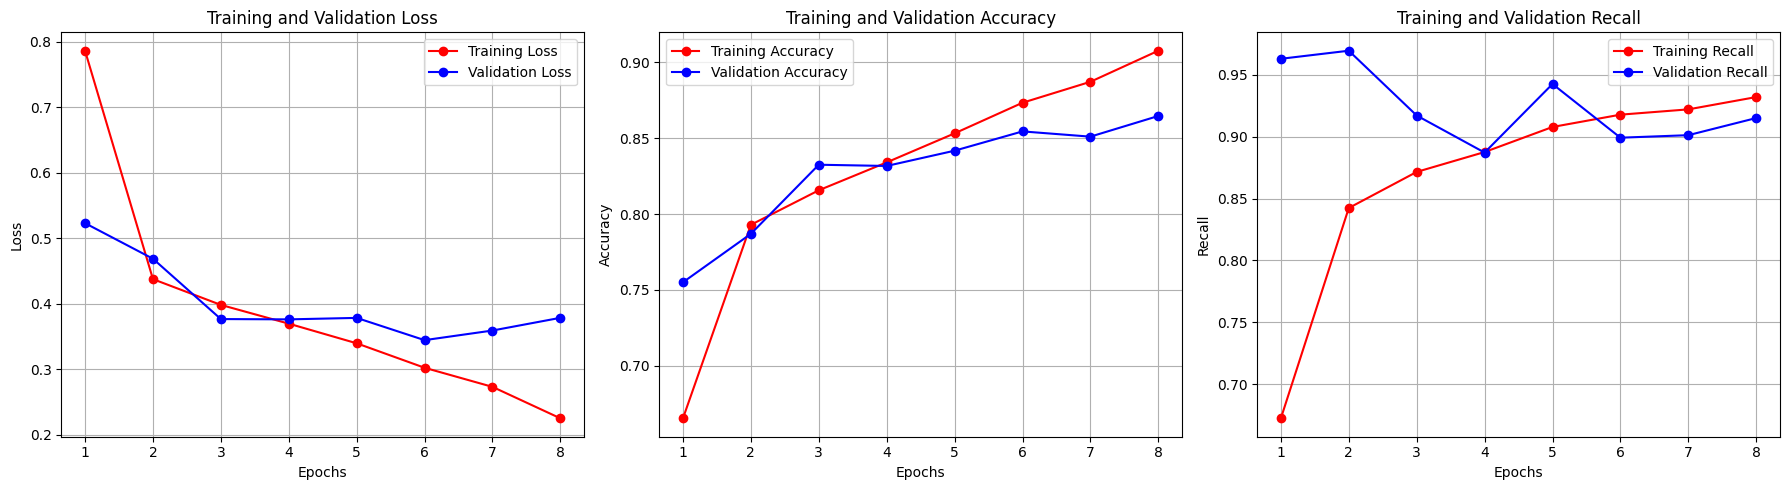

In [49]:
num_layers = 3  
CNN48 = ConvNet(num_layers=num_layers, drop_prob=0.03, initial_channels = 48).to(device)
# print(model1)
lr = 0.001
num_epochs = 8
optimizer = torch.optim.AdamW(CNN48.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()


_, _, _, _, _ = training_loop(CNN48, num_epochs, train_dataloader, val_dataloader, optimizer, criterion, device, plot_metrs = True)

By looking at the loss function above, we can see that the validation curve is not increasing, but remains rather constant just below 0.4. We can therefore say that this model is not overfitting. Moreover, accuracy increases for both the training and validation datasets.

2.9. Try to optimize three hyperparameters (the learning rate, the batch size and the number of layers in your CNN model), does it improve the performance of your model? Anwser with a graph and comment on the result. Answer this with code and Markdown. **[8 pts]**

To do so, use bayesian optimization to find the best set of hyperparameters using the library `scikit-optimize`.

`ANSWER HERE`

In [22]:
def train_model(input_batch_size, 
                input_learning_rate, 
                epochs, 
                optimizer, 
                print_model = False, 
                plot_metrics = False, 
                res_model = False, 
                layers=None, 
                block_type = None,
                num_layers = None,
                initial_channels = None,
                num_classes = 2,
                input_dim=96,
                drop_prob = 0.1):
    
    BATCH_SIZE = input_batch_size
    torch.manual_seed(42)
    train_dataset = PCAMDataset(images[train_indices], labels[train_indices], train=True)
    val_dataset = PCAMDataset(images[val_indices], labels[val_indices], train=False)
    train_dataloader = DataLoader(train_dataset, batch_size= int(BATCH_SIZE), shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=int(BATCH_SIZE), shuffle=False)
    
    if res_model:
        net_args = {
            "block": block_type,
            "layers": layers,
            "num_classes": num_classes,} 
        
        model = ResNet(**net_args).to(device)
    else:
        model = ConvNet(num_layers=num_layers, 
                        initial_channels = initial_channels,
                        num_classes = num_classes,
                        input_dim=input_dim,
                        drop_prob=drop_prob).to(device)


    if print_model:
        print(model)
    
    num_epochs = epochs

    if optimizer == 'SGD':
        optim = torch.optim.SGD(model.parameters(), lr=input_learning_rate)
    if optimizer == 'Adam':    
        optim = torch.optim.Adam(model.parameters(), lr=input_learning_rate)
    if optimizer == 'AdamW':    
        optim = torch.optim.AdamW(model.parameters(), lr=input_learning_rate)   

    criterion = torch.nn.CrossEntropyLoss()

    if plot_metrics:
        best_train_loss, best_val_loss, best_train_accuracy, best_val_accuracy, val_recall = training_loop(model, num_epochs, train_dataloader, val_dataloader, optim, criterion, device, plot_metrs = True)
    else:
        best_train_loss, best_val_loss, best_train_accuracy, best_val_accuracy, val_recall = training_loop(model, num_epochs, train_dataloader, val_dataloader, optim, criterion, device)

    return best_train_loss, best_val_loss, best_train_accuracy, best_val_accuracy, val_recall

## Define the Objective Function
### Optimization for simple CNN model

In [33]:
from skopt import gp_minimize
from skopt.space.space import Real, Integer, Categorical
from skopt.utils import use_named_args

# Define the hyperparameter configuration space
space = [
    Integer(int(2), int(4), name='num_layers'),
    Categorical(categories = [16, 32, 64, 128], name="batch_size"),
    Categorical(categories = [32, 48, 64], name="initial_channels"),
    Real(0.0001, 0.05, name='drop_prob'),
    # Categorical(['AdamW'], name='optimizer'),
    Real(0.0001, 0.01, name='learning_rate', prior='log-uniform'),
]

# Define the objective function
@use_named_args(space)
def objective(**params):

    print(f"Training with parameters: {params}")
    _, val_loss, _, _, _ = train_model(
    # _, _, _, _, val_recall = train_model(    
        input_batch_size=int(params['batch_size']),
        num_layers=params['num_layers'],
        initial_channels=int(params['initial_channels']),
        drop_prob=params['drop_prob'],
        num_classes=2,
        input_learning_rate=params['learning_rate'],
        epochs=10,
        optimizer='AdamW',
        print_model=False,
        plot_metrics=True,
    )
    # score = -val_recall
    score = val_loss
    return score

Training with parameters: {'num_layers': 3, 'batch_size': 128, 'initial_channels': 64, 'drop_prob': 0.04237786176532787, 'learning_rate': 0.0017665559365643198}
epoch: 1


100%|██████████| 77/77 [00:02<00:00, 27.26it/s]


Training Loss: 1.7576, Training Accuracy: 0.5025, Training Recall for class 1 (tumor): 0.5249
Validation Loss: 0.6843, Validation Accuracy: 0.6290, Validation Recall for class 1 (tumor): 0.9130
epoch: 2


100%|██████████| 77/77 [00:02<00:00, 27.54it/s]


Training Loss: 0.6119, Training Accuracy: 0.6395, Training Recall for class 1 (tumor): 0.7409
Validation Loss: 0.4821, Validation Accuracy: 0.7646, Validation Recall for class 1 (tumor): 0.8271
epoch: 3


100%|██████████| 77/77 [00:02<00:00, 27.43it/s]


Training Loss: 0.4733, Training Accuracy: 0.7727, Training Recall for class 1 (tumor): 0.8221
Validation Loss: 0.4273, Validation Accuracy: 0.7918, Validation Recall for class 1 (tumor): 0.7650
epoch: 4


100%|██████████| 77/77 [00:02<00:00, 27.53it/s]


Training Loss: 0.4075, Training Accuracy: 0.8121, Training Recall for class 1 (tumor): 0.8513
Validation Loss: 0.3918, Validation Accuracy: 0.8276, Validation Recall for class 1 (tumor): 0.8976
epoch: 5


100%|██████████| 77/77 [00:02<00:00, 27.57it/s]


Training Loss: 0.3712, Training Accuracy: 0.8373, Training Recall for class 1 (tumor): 0.8758
Validation Loss: 0.4179, Validation Accuracy: 0.8069, Validation Recall for class 1 (tumor): 0.8998
epoch: 6


100%|██████████| 77/77 [00:02<00:00, 27.51it/s]


Training Loss: 0.3450, Training Accuracy: 0.8504, Training Recall for class 1 (tumor): 0.8894
Validation Loss: 0.3444, Validation Accuracy: 0.8519, Validation Recall for class 1 (tumor): 0.8741
epoch: 7


100%|██████████| 77/77 [00:02<00:00, 27.50it/s]


Training Loss: 0.3107, Training Accuracy: 0.8691, Training Recall for class 1 (tumor): 0.9000
Validation Loss: 0.3444, Validation Accuracy: 0.8558, Validation Recall for class 1 (tumor): 0.8711
epoch: 8


100%|██████████| 77/77 [00:02<00:00, 27.32it/s]


Training Loss: 0.2780, Training Accuracy: 0.8853, Training Recall for class 1 (tumor): 0.9140
Validation Loss: 0.3920, Validation Accuracy: 0.8307, Validation Recall for class 1 (tumor): 0.7568
epoch: 9


100%|██████████| 77/77 [00:02<00:00, 27.49it/s]


Training Loss: 0.2380, Training Accuracy: 0.9048, Training Recall for class 1 (tumor): 0.9231
Validation Loss: 0.4183, Validation Accuracy: 0.8375, Validation Recall for class 1 (tumor): 0.8631
epoch: 10


100%|██████████| 77/77 [00:03<00:00, 24.85it/s]


Training Loss: 0.2220, Training Accuracy: 0.9110, Training Recall for class 1 (tumor): 0.9243
Validation Loss: 0.4179, Validation Accuracy: 0.8477, Validation Recall for class 1 (tumor): 0.8057


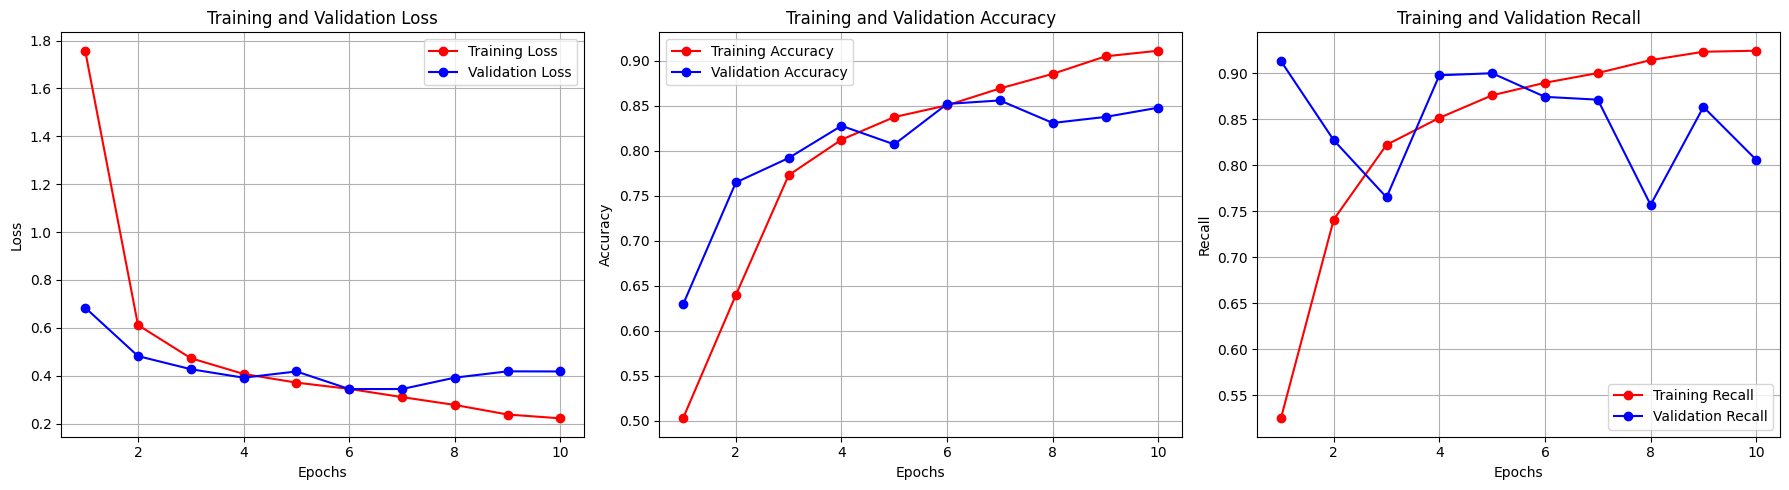

Training with parameters: {'num_layers': 3, 'batch_size': 32, 'initial_channels': 32, 'drop_prob': 0.01370554909954765, 'learning_rate': 0.000902256947026915}
epoch: 1


100%|██████████| 308/308 [00:01<00:00, 197.54it/s]


Training Loss: 0.5330, Training Accuracy: 0.7625, Training Recall for class 1 (tumor): 0.7935
Validation Loss: 0.4035, Validation Accuracy: 0.8203, Validation Recall for class 1 (tumor): 0.8727
epoch: 2


100%|██████████| 308/308 [00:01<00:00, 198.85it/s]


Training Loss: 0.4105, Training Accuracy: 0.8128, Training Recall for class 1 (tumor): 0.8521
Validation Loss: 0.3976, Validation Accuracy: 0.8252, Validation Recall for class 1 (tumor): 0.9035
epoch: 3


100%|██████████| 308/308 [00:01<00:00, 200.82it/s]


Training Loss: 0.3779, Training Accuracy: 0.8325, Training Recall for class 1 (tumor): 0.8801
Validation Loss: 0.3507, Validation Accuracy: 0.8487, Validation Recall for class 1 (tumor): 0.8770
epoch: 4


100%|██████████| 308/308 [00:01<00:00, 205.26it/s]


Training Loss: 0.3391, Training Accuracy: 0.8549, Training Recall for class 1 (tumor): 0.8970
Validation Loss: 0.3336, Validation Accuracy: 0.8556, Validation Recall for class 1 (tumor): 0.9318
epoch: 5


100%|██████████| 308/308 [00:01<00:00, 201.74it/s]


Training Loss: 0.2862, Training Accuracy: 0.8792, Training Recall for class 1 (tumor): 0.9090
Validation Loss: 0.2959, Validation Accuracy: 0.8796, Validation Recall for class 1 (tumor): 0.9143
epoch: 6


100%|██████████| 308/308 [00:01<00:00, 192.97it/s]


Training Loss: 0.2326, Training Accuracy: 0.9053, Training Recall for class 1 (tumor): 0.9270
Validation Loss: 0.3649, Validation Accuracy: 0.8510, Validation Recall for class 1 (tumor): 0.9267
epoch: 7


100%|██████████| 308/308 [00:01<00:00, 201.51it/s]


Training Loss: 0.1711, Training Accuracy: 0.9336, Training Recall for class 1 (tumor): 0.9453
Validation Loss: 0.3232, Validation Accuracy: 0.8730, Validation Recall for class 1 (tumor): 0.9212
epoch: 8


100%|██████████| 308/308 [00:01<00:00, 194.60it/s]


Training Loss: 0.1316, Training Accuracy: 0.9495, Training Recall for class 1 (tumor): 0.9574
Validation Loss: 0.3924, Validation Accuracy: 0.8726, Validation Recall for class 1 (tumor): 0.8605
epoch: 9


100%|██████████| 308/308 [00:01<00:00, 191.39it/s]


Training Loss: 0.1034, Training Accuracy: 0.9608, Training Recall for class 1 (tumor): 0.9642
Validation Loss: 0.4850, Validation Accuracy: 0.8562, Validation Recall for class 1 (tumor): 0.8393
epoch: 10


100%|██████████| 308/308 [00:01<00:00, 188.69it/s]


Training Loss: 0.0781, Training Accuracy: 0.9713, Training Recall for class 1 (tumor): 0.9735
Validation Loss: 0.4165, Validation Accuracy: 0.8758, Validation Recall for class 1 (tumor): 0.9002


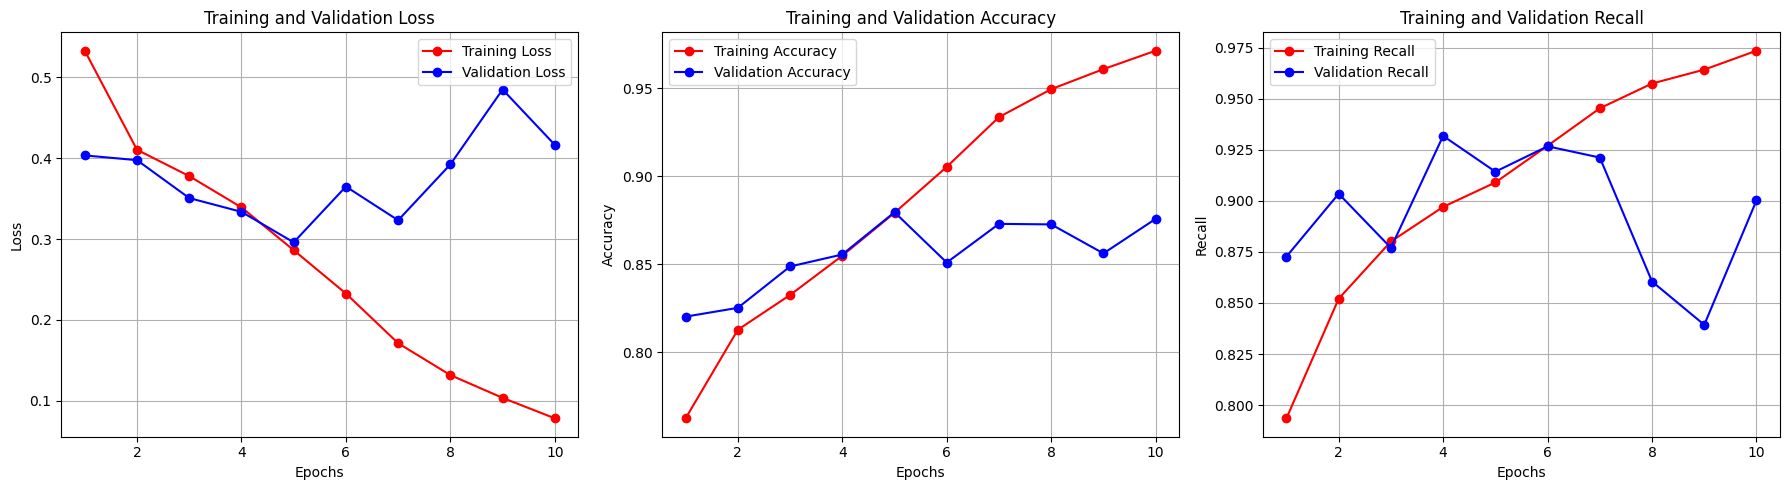

Training with parameters: {'num_layers': 4, 'batch_size': 32, 'initial_channels': 48, 'drop_prob': 0.04182033030051515, 'learning_rate': 0.00047292505261613645}
epoch: 1


100%|██████████| 308/308 [00:02<00:00, 112.42it/s]


Training Loss: 0.4803, Training Accuracy: 0.7796, Training Recall for class 1 (tumor): 0.8212
Validation Loss: 0.3944, Validation Accuracy: 0.8247, Validation Recall for class 1 (tumor): 0.8318
epoch: 2


100%|██████████| 308/308 [00:02<00:00, 132.85it/s]


Training Loss: 0.3762, Training Accuracy: 0.8350, Training Recall for class 1 (tumor): 0.8783
Validation Loss: 0.3444, Validation Accuracy: 0.8508, Validation Recall for class 1 (tumor): 0.9576
epoch: 3


100%|██████████| 308/308 [00:02<00:00, 129.28it/s]


Training Loss: 0.3181, Training Accuracy: 0.8628, Training Recall for class 1 (tumor): 0.8972
Validation Loss: 0.3516, Validation Accuracy: 0.8652, Validation Recall for class 1 (tumor): 0.8257
epoch: 4


100%|██████████| 308/308 [00:02<00:00, 130.79it/s]


Training Loss: 0.2603, Training Accuracy: 0.8909, Training Recall for class 1 (tumor): 0.9092
Validation Loss: 0.2766, Validation Accuracy: 0.8882, Validation Recall for class 1 (tumor): 0.9633
epoch: 5


100%|██████████| 308/308 [00:02<00:00, 130.50it/s]


Training Loss: 0.1975, Training Accuracy: 0.9209, Training Recall for class 1 (tumor): 0.9331
Validation Loss: 0.2341, Validation Accuracy: 0.9011, Validation Recall for class 1 (tumor): 0.9654
epoch: 6


100%|██████████| 308/308 [00:02<00:00, 127.49it/s]


Training Loss: 0.1527, Training Accuracy: 0.9409, Training Recall for class 1 (tumor): 0.9470
Validation Loss: 0.2058, Validation Accuracy: 0.9195, Validation Recall for class 1 (tumor): 0.9006
epoch: 7


100%|██████████| 308/308 [00:02<00:00, 133.27it/s]


Training Loss: 0.1074, Training Accuracy: 0.9602, Training Recall for class 1 (tumor): 0.9624
Validation Loss: 0.2646, Validation Accuracy: 0.9092, Validation Recall for class 1 (tumor): 0.8640
epoch: 8


100%|██████████| 308/308 [00:02<00:00, 131.84it/s]


Training Loss: 0.0826, Training Accuracy: 0.9688, Training Recall for class 1 (tumor): 0.9711
Validation Loss: 0.4241, Validation Accuracy: 0.8738, Validation Recall for class 1 (tumor): 0.9841
epoch: 9


100%|██████████| 308/308 [00:02<00:00, 127.08it/s]


Training Loss: 0.0647, Training Accuracy: 0.9770, Training Recall for class 1 (tumor): 0.9774
Validation Loss: 0.2762, Validation Accuracy: 0.9188, Validation Recall for class 1 (tumor): 0.9387
epoch: 10


100%|██████████| 308/308 [00:02<00:00, 131.08it/s]


Training Loss: 0.0463, Training Accuracy: 0.9826, Training Recall for class 1 (tumor): 0.9833
Validation Loss: 0.2868, Validation Accuracy: 0.9237, Validation Recall for class 1 (tumor): 0.8971


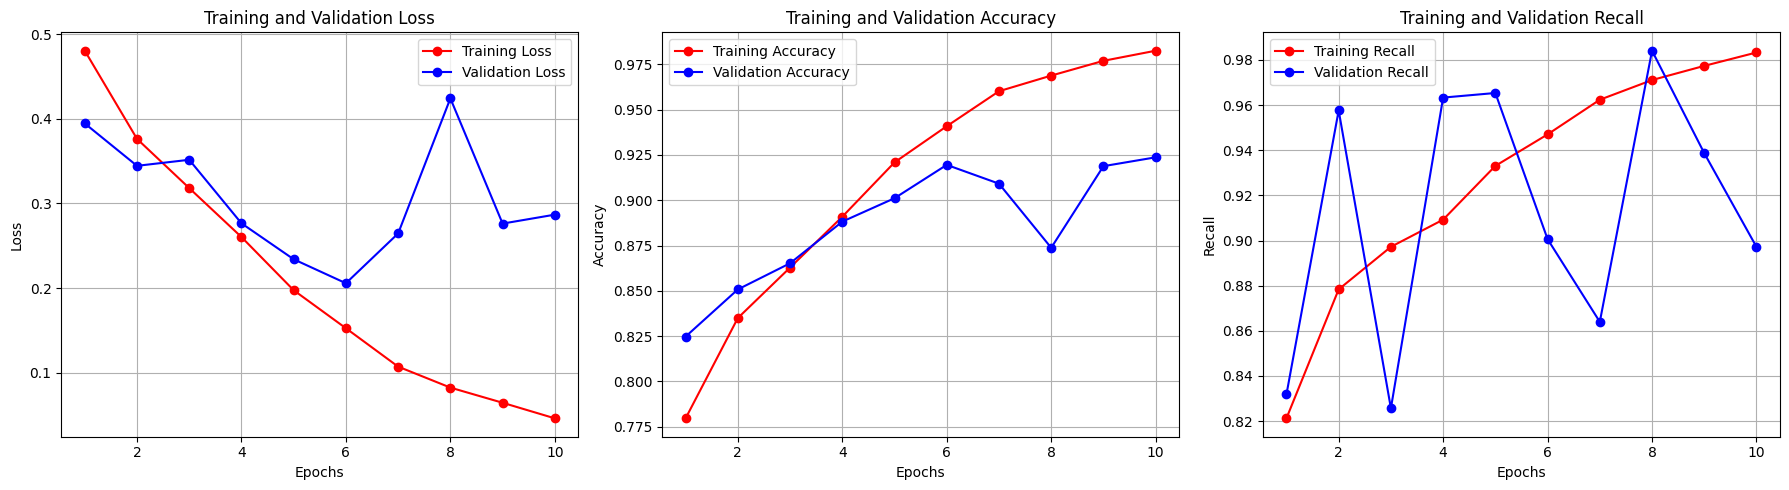

Training with parameters: {'num_layers': 3, 'batch_size': 32, 'initial_channels': 64, 'drop_prob': 0.007103503942590995, 'learning_rate': 0.005497617455119919}
epoch: 1


100%|██████████| 308/308 [00:03<00:00, 90.26it/s]


Training Loss: 1.3407, Training Accuracy: 0.5025, Training Recall for class 1 (tumor): 0.4672
Validation Loss: 0.6931, Validation Accuracy: 0.5003, Validation Recall for class 1 (tumor): 0.9988
epoch: 2


100%|██████████| 308/308 [00:03<00:00, 93.52it/s]


Training Loss: 0.6934, Training Accuracy: 0.4986, Training Recall for class 1 (tumor): 0.4883
Validation Loss: 0.6932, Validation Accuracy: 0.4994, Validation Recall for class 1 (tumor): 1.0000
epoch: 3


100%|██████████| 308/308 [00:03<00:00, 93.10it/s]


Training Loss: 0.6935, Training Accuracy: 0.4978, Training Recall for class 1 (tumor): 0.4481
Validation Loss: 0.6937, Validation Accuracy: 0.4994, Validation Recall for class 1 (tumor): 1.0000
epoch: 4


100%|██████████| 308/308 [00:03<00:00, 93.09it/s]


Training Loss: 0.6933, Training Accuracy: 0.5046, Training Recall for class 1 (tumor): 0.4269
Validation Loss: 0.6933, Validation Accuracy: 0.4994, Validation Recall for class 1 (tumor): 1.0000
epoch: 5


100%|██████████| 308/308 [00:03<00:00, 93.21it/s]


Training Loss: 0.6934, Training Accuracy: 0.4991, Training Recall for class 1 (tumor): 0.5541
Validation Loss: 0.6934, Validation Accuracy: 0.4994, Validation Recall for class 1 (tumor): 1.0000
epoch: 6


100%|██████████| 308/308 [00:03<00:00, 91.88it/s]


Training Loss: 0.6935, Training Accuracy: 0.4961, Training Recall for class 1 (tumor): 0.5639
Validation Loss: 0.6940, Validation Accuracy: 0.5006, Validation Recall for class 1 (tumor): 0.0000
epoch: 7


100%|██████████| 308/308 [00:03<00:00, 93.03it/s]


Training Loss: 0.6935, Training Accuracy: 0.4995, Training Recall for class 1 (tumor): 0.4794
Validation Loss: 0.6942, Validation Accuracy: 0.5006, Validation Recall for class 1 (tumor): 0.0000
epoch: 8


100%|██████████| 308/308 [00:03<00:00, 93.45it/s]


Training Loss: 0.6934, Training Accuracy: 0.4974, Training Recall for class 1 (tumor): 0.4522
Validation Loss: 0.6932, Validation Accuracy: 0.5006, Validation Recall for class 1 (tumor): 0.0000
epoch: 9


100%|██████████| 308/308 [00:03<00:00, 93.12it/s]


Training Loss: 0.6932, Training Accuracy: 0.5033, Training Recall for class 1 (tumor): 0.4371
Validation Loss: 0.6933, Validation Accuracy: 0.5006, Validation Recall for class 1 (tumor): 0.0000
epoch: 10


100%|██████████| 308/308 [00:03<00:00, 93.21it/s]


Training Loss: 0.6935, Training Accuracy: 0.4977, Training Recall for class 1 (tumor): 0.4493
Validation Loss: 0.6932, Validation Accuracy: 0.4994, Validation Recall for class 1 (tumor): 1.0000


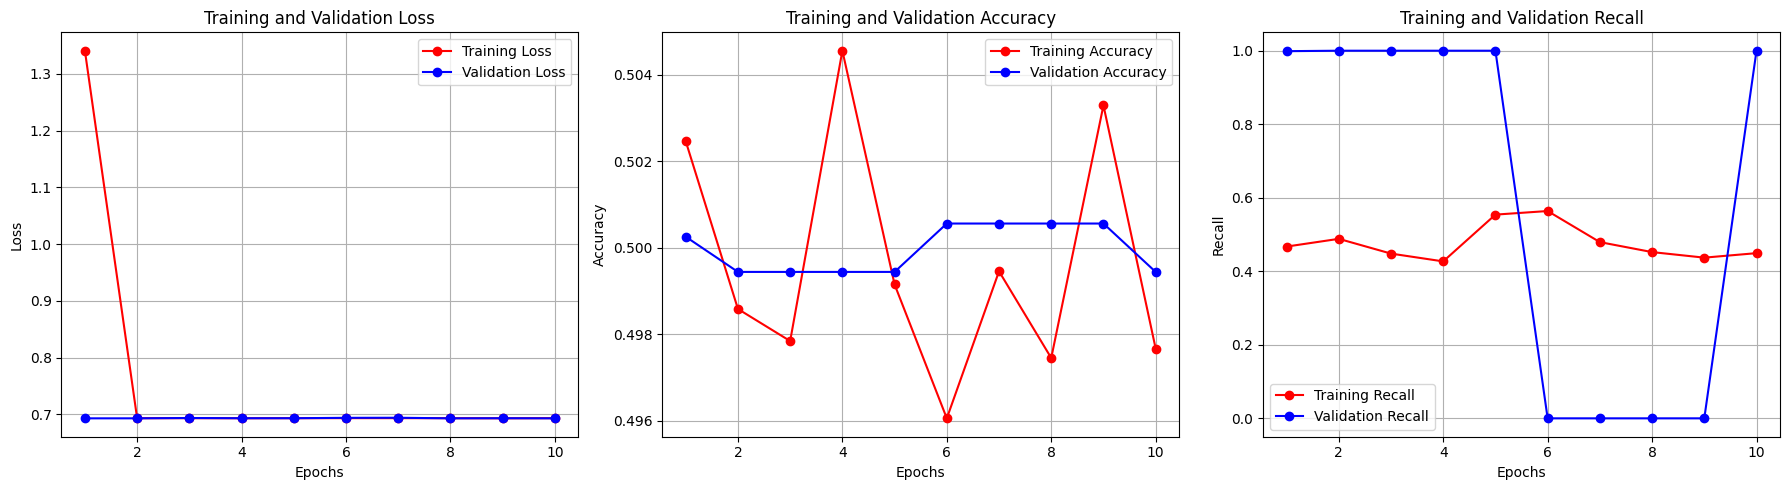

Training with parameters: {'num_layers': 3, 'batch_size': 64, 'initial_channels': 48, 'drop_prob': 0.03397608855293613, 'learning_rate': 0.002762264801799497}
epoch: 1


100%|██████████| 154/154 [00:01<00:00, 77.41it/s]


Training Loss: 1.2536, Training Accuracy: 0.5518, Training Recall for class 1 (tumor): 0.6104
Validation Loss: 0.5727, Validation Accuracy: 0.6769, Validation Recall for class 1 (tumor): 0.9387
epoch: 2


100%|██████████| 154/154 [00:01<00:00, 84.09it/s]


Training Loss: 0.5810, Training Accuracy: 0.6740, Training Recall for class 1 (tumor): 0.9294
Validation Loss: 0.5793, Validation Accuracy: 0.6795, Validation Recall for class 1 (tumor): 0.9367
epoch: 3


100%|██████████| 154/154 [00:01<00:00, 83.83it/s]


Training Loss: 0.5711, Training Accuracy: 0.6764, Training Recall for class 1 (tumor): 0.9413
Validation Loss: 0.5187, Validation Accuracy: 0.6800, Validation Recall for class 1 (tumor): 0.9595
epoch: 4


100%|██████████| 154/154 [00:01<00:00, 83.84it/s]


Training Loss: 0.4974, Training Accuracy: 0.7426, Training Recall for class 1 (tumor): 0.8057
Validation Loss: 0.4382, Validation Accuracy: 0.8106, Validation Recall for class 1 (tumor): 0.8642
epoch: 5


100%|██████████| 154/154 [00:01<00:00, 84.43it/s]


Training Loss: 0.4779, Training Accuracy: 0.7660, Training Recall for class 1 (tumor): 0.7860
Validation Loss: 0.5259, Validation Accuracy: 0.7664, Validation Recall for class 1 (tumor): 0.9570
epoch: 6


100%|██████████| 154/154 [00:01<00:00, 84.07it/s]


Training Loss: 0.4172, Training Accuracy: 0.8111, Training Recall for class 1 (tumor): 0.8498
Validation Loss: 0.4374, Validation Accuracy: 0.7760, Validation Recall for class 1 (tumor): 0.6768
epoch: 7


100%|██████████| 154/154 [00:01<00:00, 84.05it/s]


Training Loss: 0.3960, Training Accuracy: 0.8209, Training Recall for class 1 (tumor): 0.8562
Validation Loss: 0.4170, Validation Accuracy: 0.8202, Validation Recall for class 1 (tumor): 0.9330
epoch: 8


100%|██████████| 154/154 [00:01<00:00, 82.49it/s]


Training Loss: 0.3588, Training Accuracy: 0.8403, Training Recall for class 1 (tumor): 0.8647
Validation Loss: 0.3991, Validation Accuracy: 0.8101, Validation Recall for class 1 (tumor): 0.8967
epoch: 9


100%|██████████| 154/154 [00:01<00:00, 83.75it/s]


Training Loss: 0.3150, Training Accuracy: 0.8662, Training Recall for class 1 (tumor): 0.8795
Validation Loss: 0.3869, Validation Accuracy: 0.8290, Validation Recall for class 1 (tumor): 0.9020
epoch: 10


100%|██████████| 154/154 [00:01<00:00, 83.92it/s]


Training Loss: 0.2748, Training Accuracy: 0.8844, Training Recall for class 1 (tumor): 0.8838
Validation Loss: 0.3578, Validation Accuracy: 0.8453, Validation Recall for class 1 (tumor): 0.8432


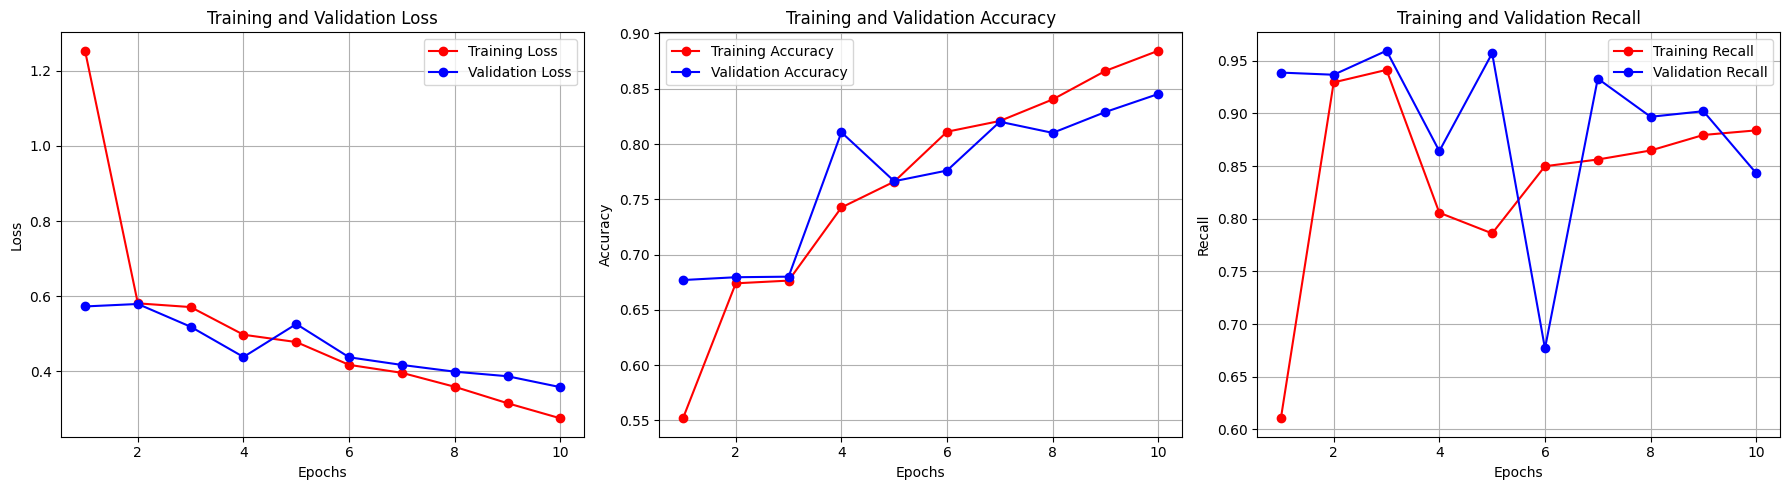

Training with parameters: {'num_layers': 3, 'batch_size': 64, 'initial_channels': 64, 'drop_prob': 0.005384789598670829, 'learning_rate': 0.0008855250245941234}
epoch: 1


100%|██████████| 154/154 [00:03<00:00, 50.53it/s]


Training Loss: 0.7396, Training Accuracy: 0.6780, Training Recall for class 1 (tumor): 0.6947
Validation Loss: 0.4886, Validation Accuracy: 0.7540, Validation Recall for class 1 (tumor): 0.9619
epoch: 2


100%|██████████| 154/154 [00:02<00:00, 52.58it/s]


Training Loss: 0.4334, Training Accuracy: 0.7978, Training Recall for class 1 (tumor): 0.8393
Validation Loss: 0.3883, Validation Accuracy: 0.8211, Validation Recall for class 1 (tumor): 0.8866
epoch: 3


100%|██████████| 154/154 [00:02<00:00, 52.40it/s]


Training Loss: 0.3815, Training Accuracy: 0.8274, Training Recall for class 1 (tumor): 0.8804
Validation Loss: 0.4004, Validation Accuracy: 0.8042, Validation Recall for class 1 (tumor): 0.7462
epoch: 4


100%|██████████| 154/154 [00:02<00:00, 52.43it/s]


Training Loss: 0.3578, Training Accuracy: 0.8430, Training Recall for class 1 (tumor): 0.8953
Validation Loss: 0.3516, Validation Accuracy: 0.8423, Validation Recall for class 1 (tumor): 0.8611
epoch: 5


100%|██████████| 154/154 [00:02<00:00, 52.46it/s]


Training Loss: 0.3171, Training Accuracy: 0.8655, Training Recall for class 1 (tumor): 0.9044
Validation Loss: 0.3254, Validation Accuracy: 0.8626, Validation Recall for class 1 (tumor): 0.9104
epoch: 6


100%|██████████| 154/154 [00:02<00:00, 52.60it/s]


Training Loss: 0.2715, Training Accuracy: 0.8889, Training Recall for class 1 (tumor): 0.9158
Validation Loss: 0.3451, Validation Accuracy: 0.8520, Validation Recall for class 1 (tumor): 0.9043
epoch: 7


100%|██████████| 154/154 [00:02<00:00, 52.62it/s]


Training Loss: 0.2212, Training Accuracy: 0.9113, Training Recall for class 1 (tumor): 0.9302
Validation Loss: 0.3550, Validation Accuracy: 0.8720, Validation Recall for class 1 (tumor): 0.8888
epoch: 8


100%|██████████| 154/154 [00:02<00:00, 52.51it/s]


Training Loss: 0.1749, Training Accuracy: 0.9324, Training Recall for class 1 (tumor): 0.9448
Validation Loss: 0.4220, Validation Accuracy: 0.8357, Validation Recall for class 1 (tumor): 0.8961
epoch: 9


100%|██████████| 154/154 [00:02<00:00, 52.63it/s]


Training Loss: 0.1184, Training Accuracy: 0.9564, Training Recall for class 1 (tumor): 0.9646
Validation Loss: 0.4422, Validation Accuracy: 0.8604, Validation Recall for class 1 (tumor): 0.8487
epoch: 10


100%|██████████| 154/154 [00:02<00:00, 52.53it/s]


Training Loss: 0.0887, Training Accuracy: 0.9686, Training Recall for class 1 (tumor): 0.9743
Validation Loss: 0.4962, Validation Accuracy: 0.8566, Validation Recall for class 1 (tumor): 0.8619


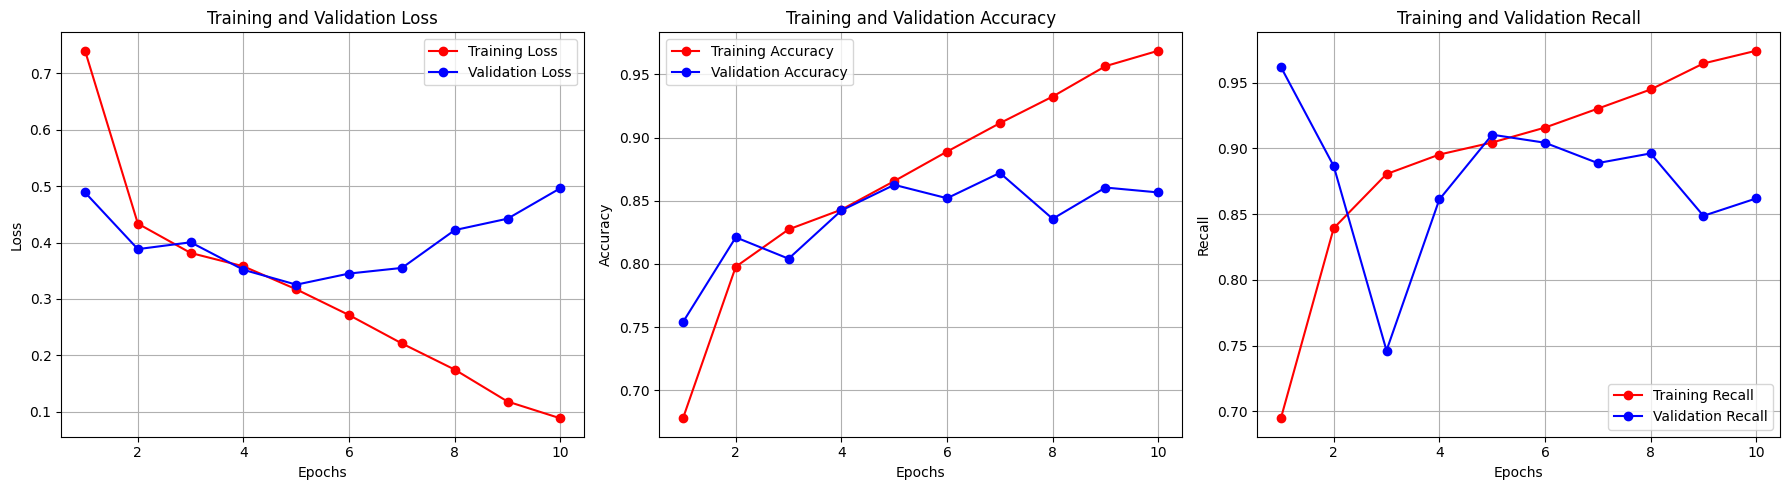

Training with parameters: {'num_layers': 2, 'batch_size': 64, 'initial_channels': 32, 'drop_prob': 0.00684738685293206, 'learning_rate': 0.0004449200891662953}
epoch: 1


100%|██████████| 154/154 [00:01<00:00, 87.24it/s]


Training Loss: 0.5534, Training Accuracy: 0.7728, Training Recall for class 1 (tumor): 0.8148
Validation Loss: 0.3846, Validation Accuracy: 0.8258, Validation Recall for class 1 (tumor): 0.8831
epoch: 2


100%|██████████| 154/154 [00:01<00:00, 91.12it/s]


Training Loss: 0.3618, Training Accuracy: 0.8428, Training Recall for class 1 (tumor): 0.8789
Validation Loss: 0.3632, Validation Accuracy: 0.8423, Validation Recall for class 1 (tumor): 0.8259
epoch: 3


100%|██████████| 154/154 [00:01<00:00, 89.93it/s]


Training Loss: 0.2799, Training Accuracy: 0.8835, Training Recall for class 1 (tumor): 0.9091
Validation Loss: 0.3365, Validation Accuracy: 0.8621, Validation Recall for class 1 (tumor): 0.8731
epoch: 4


100%|██████████| 154/154 [00:01<00:00, 89.71it/s]


Training Loss: 0.1688, Training Accuracy: 0.9343, Training Recall for class 1 (tumor): 0.9407
Validation Loss: 0.5234, Validation Accuracy: 0.8333, Validation Recall for class 1 (tumor): 0.9424
epoch: 5


100%|██████████| 154/154 [00:01<00:00, 90.82it/s]


Training Loss: 0.0994, Training Accuracy: 0.9625, Training Recall for class 1 (tumor): 0.9649
Validation Loss: 0.5933, Validation Accuracy: 0.8582, Validation Recall for class 1 (tumor): 0.8678
epoch: 6


100%|██████████| 154/154 [00:01<00:00, 90.37it/s]


Training Loss: 0.0461, Training Accuracy: 0.9834, Training Recall for class 1 (tumor): 0.9829
Validation Loss: 0.6743, Validation Accuracy: 0.8513, Validation Recall for class 1 (tumor): 0.8953
epoch: 7


100%|██████████| 154/154 [00:01<00:00, 91.18it/s]


Training Loss: 0.0316, Training Accuracy: 0.9883, Training Recall for class 1 (tumor): 0.9883
Validation Loss: 0.6987, Validation Accuracy: 0.8478, Validation Recall for class 1 (tumor): 0.8409
epoch: 8


100%|██████████| 154/154 [00:01<00:00, 88.20it/s]


Training Loss: 0.0139, Training Accuracy: 0.9954, Training Recall for class 1 (tumor): 0.9955
Validation Loss: 0.8559, Validation Accuracy: 0.8467, Validation Recall for class 1 (tumor): 0.8953
epoch: 9


100%|██████████| 154/154 [00:01<00:00, 89.31it/s]


Training Loss: 0.0193, Training Accuracy: 0.9935, Training Recall for class 1 (tumor): 0.9932
Validation Loss: 0.7847, Validation Accuracy: 0.8536, Validation Recall for class 1 (tumor): 0.9045
epoch: 10


100%|██████████| 154/154 [00:01<00:00, 91.43it/s]


Training Loss: 0.0770, Training Accuracy: 0.9725, Training Recall for class 1 (tumor): 0.9735
Validation Loss: 0.6991, Validation Accuracy: 0.8458, Validation Recall for class 1 (tumor): 0.8855


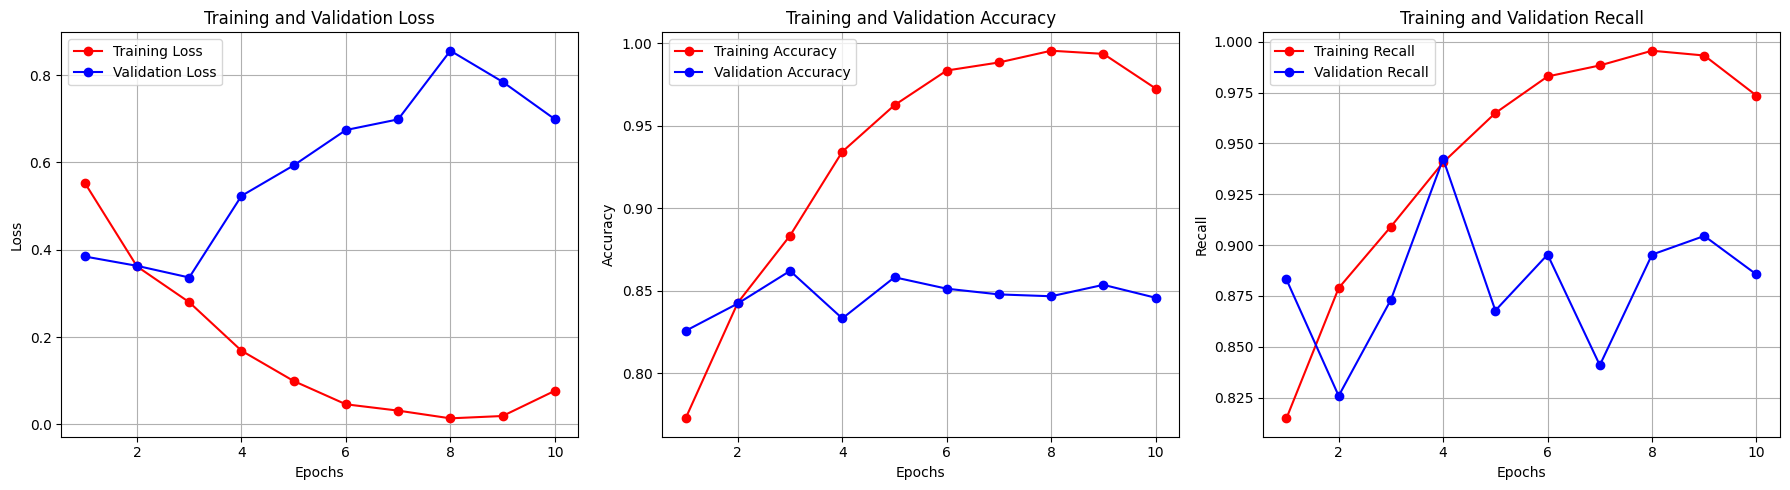

Training with parameters: {'num_layers': 2, 'batch_size': 32, 'initial_channels': 48, 'drop_prob': 0.04513966392891731, 'learning_rate': 0.0007941453180482805}
epoch: 1


100%|██████████| 308/308 [00:02<00:00, 116.86it/s]


Training Loss: 0.6352, Training Accuracy: 0.7673, Training Recall for class 1 (tumor): 0.8005
Validation Loss: 0.4044, Validation Accuracy: 0.8133, Validation Recall for class 1 (tumor): 0.8090
epoch: 2


100%|██████████| 308/308 [00:02<00:00, 115.85it/s]


Training Loss: 0.3787, Training Accuracy: 0.8343, Training Recall for class 1 (tumor): 0.8670
Validation Loss: 0.3981, Validation Accuracy: 0.8292, Validation Recall for class 1 (tumor): 0.8607
epoch: 3


100%|██████████| 308/308 [00:02<00:00, 135.15it/s]


Training Loss: 0.3120, Training Accuracy: 0.8683, Training Recall for class 1 (tumor): 0.8915
Validation Loss: 0.3283, Validation Accuracy: 0.8569, Validation Recall for class 1 (tumor): 0.9049
epoch: 4


100%|██████████| 308/308 [00:02<00:00, 118.82it/s]


Training Loss: 0.2095, Training Accuracy: 0.9166, Training Recall for class 1 (tumor): 0.9272
Validation Loss: 0.3634, Validation Accuracy: 0.8600, Validation Recall for class 1 (tumor): 0.9183
epoch: 5


100%|██████████| 308/308 [00:02<00:00, 137.53it/s]


Training Loss: 0.1393, Training Accuracy: 0.9469, Training Recall for class 1 (tumor): 0.9537
Validation Loss: 0.4392, Validation Accuracy: 0.8601, Validation Recall for class 1 (tumor): 0.8558
epoch: 6


100%|██████████| 308/308 [00:02<00:00, 117.15it/s]


Training Loss: 0.1093, Training Accuracy: 0.9595, Training Recall for class 1 (tumor): 0.9625
Validation Loss: 0.6655, Validation Accuracy: 0.8241, Validation Recall for class 1 (tumor): 0.9265
epoch: 7


100%|██████████| 308/308 [00:02<00:00, 115.81it/s]


Training Loss: 0.0774, Training Accuracy: 0.9725, Training Recall for class 1 (tumor): 0.9745
Validation Loss: 0.5598, Validation Accuracy: 0.8624, Validation Recall for class 1 (tumor): 0.8739
epoch: 8


100%|██████████| 308/308 [00:02<00:00, 117.42it/s]


Training Loss: 0.0514, Training Accuracy: 0.9805, Training Recall for class 1 (tumor): 0.9812
Validation Loss: 0.8194, Validation Accuracy: 0.8398, Validation Recall for class 1 (tumor): 0.9326
epoch: 9


100%|██████████| 308/308 [00:02<00:00, 118.83it/s]


Training Loss: 0.0477, Training Accuracy: 0.9837, Training Recall for class 1 (tumor): 0.9839
Validation Loss: 0.7093, Validation Accuracy: 0.8515, Validation Recall for class 1 (tumor): 0.8868
epoch: 10


100%|██████████| 308/308 [00:02<00:00, 117.27it/s]


Training Loss: 0.0434, Training Accuracy: 0.9834, Training Recall for class 1 (tumor): 0.9838
Validation Loss: 0.8547, Validation Accuracy: 0.8509, Validation Recall for class 1 (tumor): 0.8454


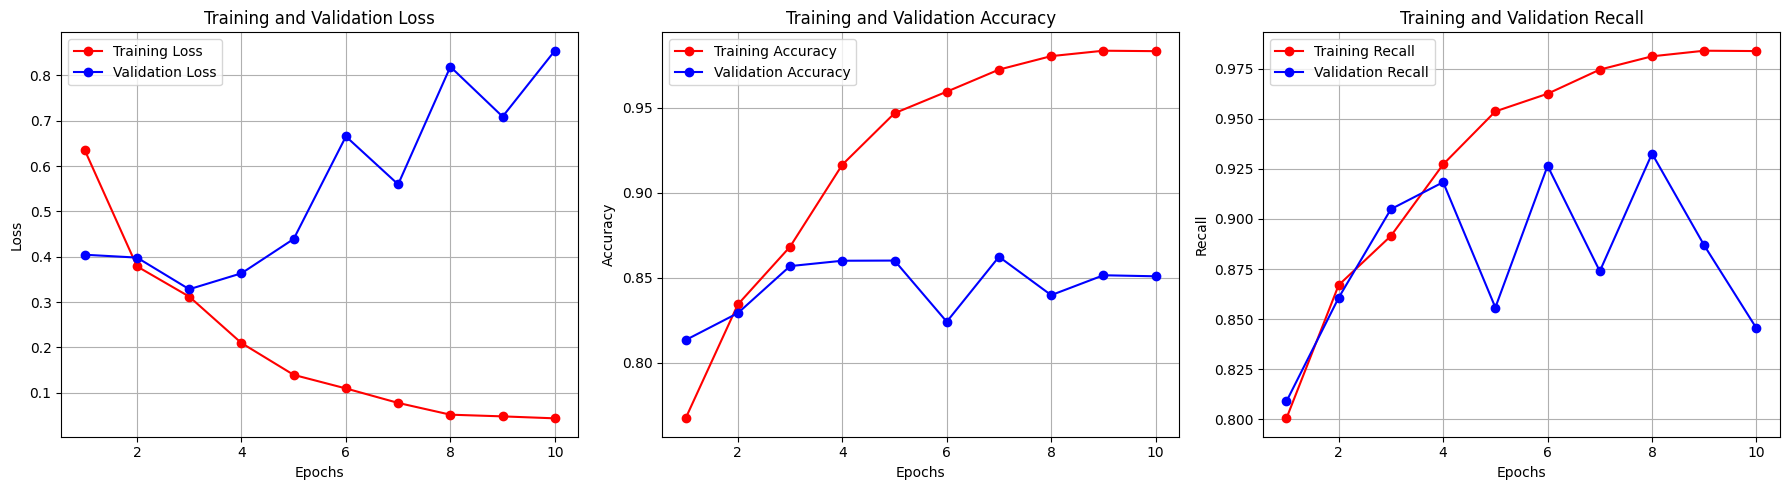

Training with parameters: {'num_layers': 3, 'batch_size': 128, 'initial_channels': 32, 'drop_prob': 0.04849347248056278, 'learning_rate': 0.0020243242216078086}
epoch: 1


100%|██████████| 77/77 [00:01<00:00, 59.85it/s]


Training Loss: 1.2003, Training Accuracy: 0.6106, Training Recall for class 1 (tumor): 0.6300
Validation Loss: 0.4761, Validation Accuracy: 0.7623, Validation Recall for class 1 (tumor): 0.6534
epoch: 2


100%|██████████| 77/77 [00:01<00:00, 64.15it/s]


Training Loss: 0.4390, Training Accuracy: 0.7937, Training Recall for class 1 (tumor): 0.8337
Validation Loss: 0.4990, Validation Accuracy: 0.7593, Validation Recall for class 1 (tumor): 0.6990
epoch: 3


100%|██████████| 77/77 [00:01<00:00, 63.95it/s]


Training Loss: 0.4132, Training Accuracy: 0.8086, Training Recall for class 1 (tumor): 0.8635
Validation Loss: 0.4697, Validation Accuracy: 0.7743, Validation Recall for class 1 (tumor): 0.7868
epoch: 4


100%|██████████| 77/77 [00:01<00:00, 64.10it/s]


Training Loss: 0.3942, Training Accuracy: 0.8231, Training Recall for class 1 (tumor): 0.8774
Validation Loss: 0.3747, Validation Accuracy: 0.8326, Validation Recall for class 1 (tumor): 0.8383
epoch: 5


100%|██████████| 77/77 [00:01<00:00, 64.13it/s]


Training Loss: 0.3646, Training Accuracy: 0.8383, Training Recall for class 1 (tumor): 0.8962
Validation Loss: 0.3698, Validation Accuracy: 0.8348, Validation Recall for class 1 (tumor): 0.9379
epoch: 6


100%|██████████| 77/77 [00:01<00:00, 64.40it/s]


Training Loss: 0.3423, Training Accuracy: 0.8538, Training Recall for class 1 (tumor): 0.9115
Validation Loss: 0.3753, Validation Accuracy: 0.8366, Validation Recall for class 1 (tumor): 0.7851
epoch: 7


100%|██████████| 77/77 [00:01<00:00, 63.75it/s]


Training Loss: 0.3180, Training Accuracy: 0.8643, Training Recall for class 1 (tumor): 0.9103
Validation Loss: 0.3673, Validation Accuracy: 0.8474, Validation Recall for class 1 (tumor): 0.9049
epoch: 8


100%|██████████| 77/77 [00:01<00:00, 64.40it/s]


Training Loss: 0.3071, Training Accuracy: 0.8749, Training Recall for class 1 (tumor): 0.9174
Validation Loss: 0.4757, Validation Accuracy: 0.7354, Validation Recall for class 1 (tumor): 0.5255
epoch: 9


100%|██████████| 77/77 [00:01<00:00, 64.50it/s]


Training Loss: 0.2734, Training Accuracy: 0.8871, Training Recall for class 1 (tumor): 0.9208
Validation Loss: 0.3455, Validation Accuracy: 0.8517, Validation Recall for class 1 (tumor): 0.9371
epoch: 10


100%|██████████| 77/77 [00:01<00:00, 63.30it/s]


Training Loss: 0.2474, Training Accuracy: 0.8974, Training Recall for class 1 (tumor): 0.9181
Validation Loss: 0.3756, Validation Accuracy: 0.8626, Validation Recall for class 1 (tumor): 0.9226


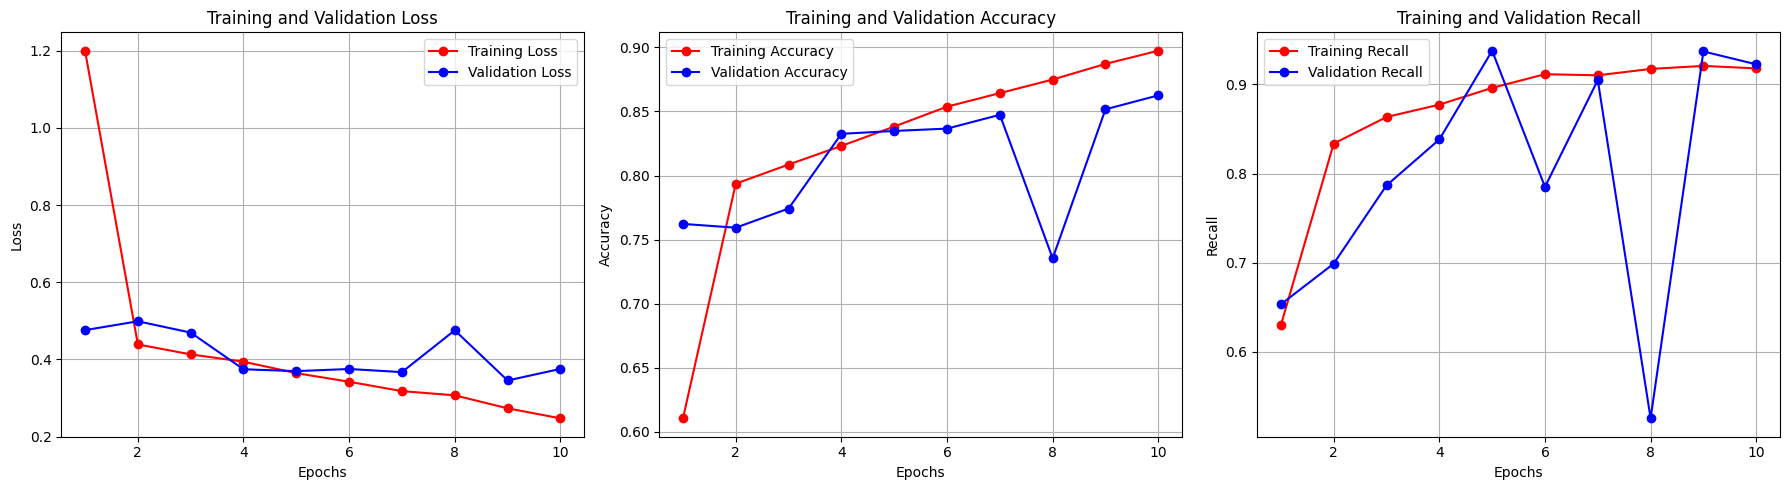

Training with parameters: {'num_layers': 2, 'batch_size': 32, 'initial_channels': 64, 'drop_prob': 0.030430750368901846, 'learning_rate': 0.00044678075533567343}
epoch: 1


100%|██████████| 308/308 [00:03<00:00, 86.95it/s]


Training Loss: 0.6472, Training Accuracy: 0.7354, Training Recall for class 1 (tumor): 0.7588
Validation Loss: 0.4205, Validation Accuracy: 0.8003, Validation Recall for class 1 (tumor): 0.7796
epoch: 2


100%|██████████| 308/308 [00:03<00:00, 88.20it/s]


Training Loss: 0.3884, Training Accuracy: 0.8264, Training Recall for class 1 (tumor): 0.8622
Validation Loss: 0.3539, Validation Accuracy: 0.8501, Validation Recall for class 1 (tumor): 0.8697
epoch: 3


100%|██████████| 308/308 [00:03<00:00, 87.18it/s]


Training Loss: 0.3079, Training Accuracy: 0.8704, Training Recall for class 1 (tumor): 0.8969
Validation Loss: 0.3743, Validation Accuracy: 0.8378, Validation Recall for class 1 (tumor): 0.9436
epoch: 4


100%|██████████| 308/308 [00:03<00:00, 87.23it/s]


Training Loss: 0.2205, Training Accuracy: 0.9131, Training Recall for class 1 (tumor): 0.9295
Validation Loss: 0.4040, Validation Accuracy: 0.8460, Validation Recall for class 1 (tumor): 0.8493
epoch: 5


100%|██████████| 308/308 [00:03<00:00, 88.33it/s]


Training Loss: 0.1406, Training Accuracy: 0.9479, Training Recall for class 1 (tumor): 0.9544
Validation Loss: 0.4711, Validation Accuracy: 0.8456, Validation Recall for class 1 (tumor): 0.8206
epoch: 6


100%|██████████| 308/308 [00:03<00:00, 87.29it/s]


Training Loss: 0.0942, Training Accuracy: 0.9656, Training Recall for class 1 (tumor): 0.9679
Validation Loss: 0.5626, Validation Accuracy: 0.8603, Validation Recall for class 1 (tumor): 0.8503
epoch: 7


100%|██████████| 308/308 [00:03<00:00, 91.66it/s]


Training Loss: 0.0683, Training Accuracy: 0.9753, Training Recall for class 1 (tumor): 0.9758
Validation Loss: 0.6995, Validation Accuracy: 0.8408, Validation Recall for class 1 (tumor): 0.7827
epoch: 8


100%|██████████| 308/308 [00:03<00:00, 89.06it/s]


Training Loss: 0.0391, Training Accuracy: 0.9864, Training Recall for class 1 (tumor): 0.9866
Validation Loss: 0.8275, Validation Accuracy: 0.8415, Validation Recall for class 1 (tumor): 0.9114
epoch: 9


100%|██████████| 308/308 [00:03<00:00, 86.79it/s]


Training Loss: 0.0347, Training Accuracy: 0.9883, Training Recall for class 1 (tumor): 0.9894
Validation Loss: 0.7053, Validation Accuracy: 0.8540, Validation Recall for class 1 (tumor): 0.8171
epoch: 10


100%|██████████| 308/308 [00:03<00:00, 87.60it/s]


Training Loss: 0.0432, Training Accuracy: 0.9848, Training Recall for class 1 (tumor): 0.9855
Validation Loss: 0.6476, Validation Accuracy: 0.8434, Validation Recall for class 1 (tumor): 0.9122


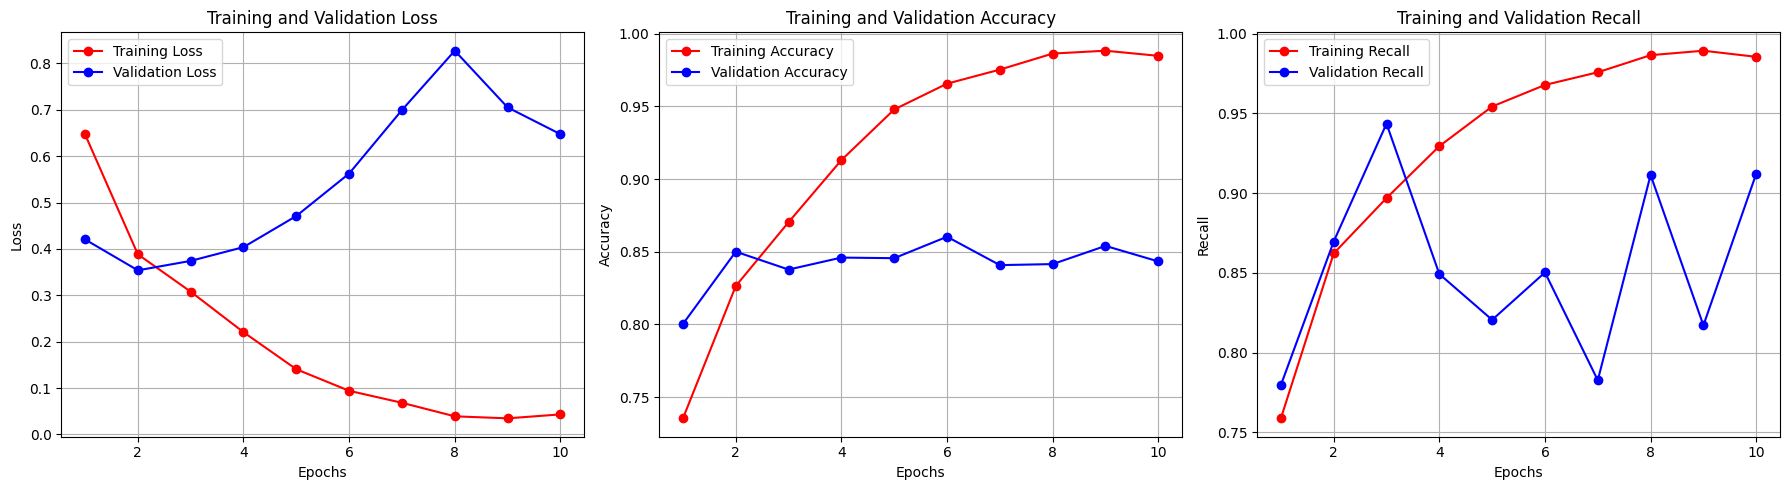

Best parameters: [4, 32, 48, 0.04182033030051515, 0.00047292505261613645]


In [34]:
# Run Bayesian optimization
results = gp_minimize(objective, space, n_calls=10, random_state=0)

# Best hyperparameters
print("Best parameters: {}".format(results.x))


In [35]:
print(f"Optimal set of parameters found at iteration {np.argmin(results.func_vals)}")
print(results.x)

Optimal set of parameters found at iteration 2
[4, 32, 48, 0.04182033030051515, 0.00047292505261613645]


## Results of the hyper parameter tuning
After running hyper parameter tuning on both the model types (simpler CNN and ResNet), we achieve rather good results with both of them. Let's analyze the simpler CNN results first, and then the ResNet ones.

### Simpler CNN Hyperparameter tuning results
The best parameters are the following: 
- 'num_layers': 4 
- 'batch_size': 32
- 'initial_channels': 48
- 'drop_prob': 0.04182033030051515
- 'learning_rate': 0.00047292505261613645

By restoring the weights to the epoch with the lowest validation loss we get the least overfitting.
With these parameters, the lowest loss is at epoch 6, with a value of **0.2058**. Its correspondent validation accuracy is **91.95%** and the validation recall for class 1 (tumor) is **96.54%**.
Below is a screenshot of these results.  

![Simpler CNN best model](hyperparameter_results/CNN48.png)

## Define the Objective Function
### Optimization for modular ResNet model

In [44]:
# Retrieve the best set of hyperparameters using bayesian optimization.
dimensions = [Real(0.0001, 0.01, prior='log-uniform', name="learning_rate"),
              Categorical(categories = [16, 32, 64, 128],  name="batch_size"),
              Categorical(categories = [BasicBlock, Bottleneck], name="block_type"),
              Integer(1, 8,  name="numblocks_1"),
              Integer(1, 8,  name="numblocks_2"),
              Integer(1, 8,  name="numblocks_3"),
              Integer(1, 8,  name="numblocks_4"),]
              # Categorical(['SGD'], name='optimizer'),] # list of your search spaces


parameters_default_values = [0.001, 16, BasicBlock , 2, 2, 2, 2] # default value for each parameter for initialization

In [47]:
# Create a function that take as input your set of hyperparameters and return a score to be minimized (choose wisely your scoring function)

@use_named_args(dimensions=dimensions)
def objective(**params):

    print(f"Training with parameters: {params}")
    _, val_loss, _, _, _ = train_model(
    # _, _, _, _, val_recall = train_model(    
        res_model = True,
        input_batch_size=int(params['batch_size']),
        block_type = params['block_type'],
        layers = [params['numblocks_1'], params['numblocks_2'], params['numblocks_3'], params['numblocks_4']],
        # num_layers=params['num_layers'],
        # initial_channels=params['initial_channels'],
        # drop_prob=params['drop_prob'],
        num_classes=2,
        input_learning_rate=params['learning_rate'],
        epochs=15,
        optimizer='AdamW',
        print_model=False,
        plot_metrics=True,
    )
    # score = -val_recall
    score = val_loss
    return score


Training with parameters: {'learning_rate': 0.0015335192657991573, 'batch_size': 128, 'block_type': <class '__main__.Bottleneck'>, 'numblocks_1': 7, 'numblocks_2': 5, 'numblocks_3': 4, 'numblocks_4': 3}
epoch: 1


100%|██████████| 77/77 [00:02<00:00, 38.40it/s]


Training Loss: 0.4287, Training Accuracy: 0.8076, Training Recall for class 1 (tumor): 0.8386
Validation Loss: 0.3878, Validation Accuracy: 0.8217, Validation Recall for class 1 (tumor): 0.7703
epoch: 2


100%|██████████| 77/77 [00:02<00:00, 38.06it/s]


Training Loss: 0.3193, Training Accuracy: 0.8670, Training Recall for class 1 (tumor): 0.8962
Validation Loss: 0.4204, Validation Accuracy: 0.8557, Validation Recall for class 1 (tumor): 0.9676
epoch: 3


100%|██████████| 77/77 [00:02<00:00, 37.23it/s]


Training Loss: 0.2755, Training Accuracy: 0.8865, Training Recall for class 1 (tumor): 0.9036
Validation Loss: 0.3060, Validation Accuracy: 0.8711, Validation Recall for class 1 (tumor): 0.8766
epoch: 4


100%|██████████| 77/77 [00:02<00:00, 38.10it/s]


Training Loss: 0.2489, Training Accuracy: 0.8982, Training Recall for class 1 (tumor): 0.9110
Validation Loss: 0.3626, Validation Accuracy: 0.8545, Validation Recall for class 1 (tumor): 0.9481
epoch: 5


100%|██████████| 77/77 [00:02<00:00, 38.10it/s]


Training Loss: 0.2259, Training Accuracy: 0.9093, Training Recall for class 1 (tumor): 0.9209
Validation Loss: 0.2368, Validation Accuracy: 0.9023, Validation Recall for class 1 (tumor): 0.9485
epoch: 6


100%|██████████| 77/77 [00:02<00:00, 37.78it/s]


Training Loss: 0.1877, Training Accuracy: 0.9271, Training Recall for class 1 (tumor): 0.9345
Validation Loss: 0.4691, Validation Accuracy: 0.8193, Validation Recall for class 1 (tumor): 0.8031
epoch: 7


100%|██████████| 77/77 [00:02<00:00, 37.96it/s]


Training Loss: 0.1635, Training Accuracy: 0.9371, Training Recall for class 1 (tumor): 0.9438
Validation Loss: 0.2251, Validation Accuracy: 0.9140, Validation Recall for class 1 (tumor): 0.9065
epoch: 8


100%|██████████| 77/77 [00:02<00:00, 37.96it/s]


Training Loss: 0.1495, Training Accuracy: 0.9417, Training Recall for class 1 (tumor): 0.9481
Validation Loss: 0.2173, Validation Accuracy: 0.9184, Validation Recall for class 1 (tumor): 0.9041
epoch: 9


100%|██████████| 77/77 [00:02<00:00, 37.84it/s]


Training Loss: 0.1343, Training Accuracy: 0.9473, Training Recall for class 1 (tumor): 0.9516
Validation Loss: 0.2238, Validation Accuracy: 0.9112, Validation Recall for class 1 (tumor): 0.9165
epoch: 10


100%|██████████| 77/77 [00:02<00:00, 37.93it/s]


Training Loss: 0.1221, Training Accuracy: 0.9537, Training Recall for class 1 (tumor): 0.9578
Validation Loss: 0.3274, Validation Accuracy: 0.8756, Validation Recall for class 1 (tumor): 0.8281
epoch: 11


100%|██████████| 77/77 [00:02<00:00, 37.49it/s]


Training Loss: 0.1067, Training Accuracy: 0.9595, Training Recall for class 1 (tumor): 0.9633
Validation Loss: 0.6362, Validation Accuracy: 0.8045, Validation Recall for class 1 (tumor): 0.6448
epoch: 12


100%|██████████| 77/77 [00:02<00:00, 37.73it/s]


Training Loss: 0.1106, Training Accuracy: 0.9568, Training Recall for class 1 (tumor): 0.9597
Validation Loss: 0.2838, Validation Accuracy: 0.8993, Validation Recall for class 1 (tumor): 0.9114
epoch: 13


100%|██████████| 77/77 [00:02<00:00, 36.10it/s]


Training Loss: 0.0899, Training Accuracy: 0.9656, Training Recall for class 1 (tumor): 0.9688
Validation Loss: 0.2444, Validation Accuracy: 0.9150, Validation Recall for class 1 (tumor): 0.8662
epoch: 14


100%|██████████| 77/77 [00:02<00:00, 36.93it/s]


Training Loss: 0.0805, Training Accuracy: 0.9700, Training Recall for class 1 (tumor): 0.9721
Validation Loss: 0.2157, Validation Accuracy: 0.9263, Validation Recall for class 1 (tumor): 0.9043
epoch: 15


100%|██████████| 77/77 [00:02<00:00, 37.93it/s]


Training Loss: 0.0797, Training Accuracy: 0.9701, Training Recall for class 1 (tumor): 0.9724
Validation Loss: 0.6422, Validation Accuracy: 0.8031, Validation Recall for class 1 (tumor): 0.6216


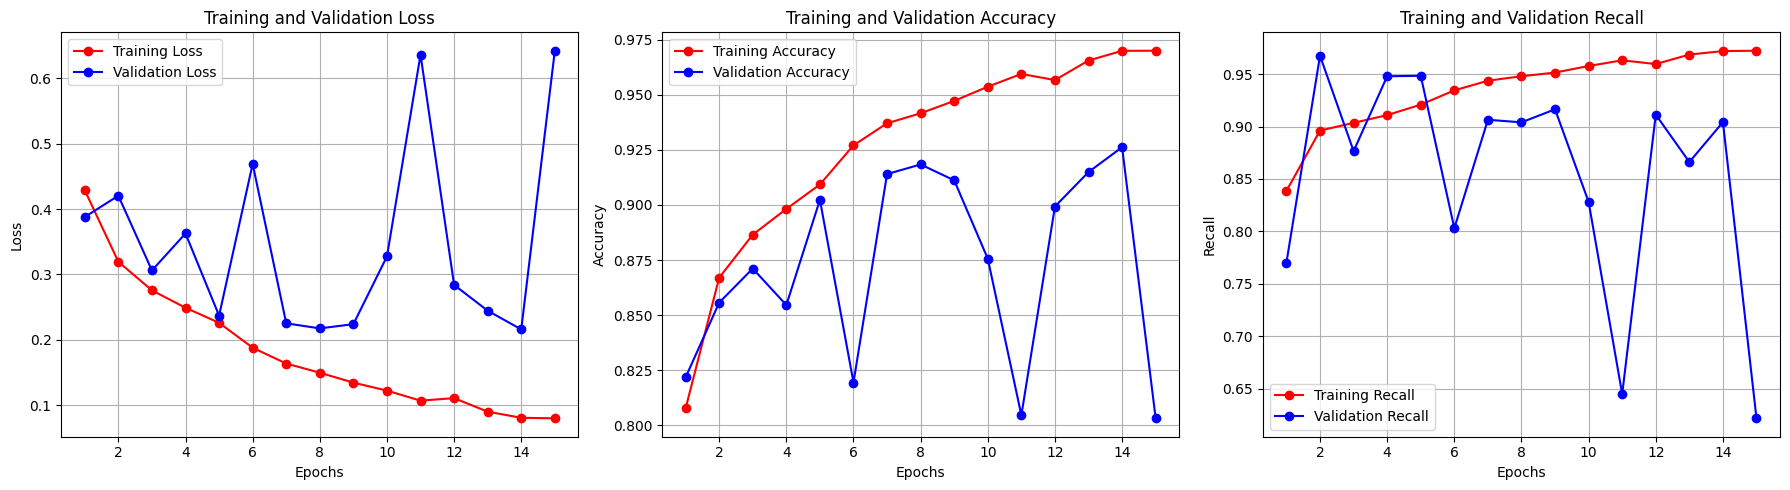

Training with parameters: {'learning_rate': 0.00012984521643751783, 'batch_size': 32, 'block_type': <class '__main__.BasicBlock'>, 'numblocks_1': 7, 'numblocks_2': 4, 'numblocks_3': 4, 'numblocks_4': 7}
epoch: 1


100%|██████████| 308/308 [00:03<00:00, 82.74it/s]


Training Loss: 0.4577, Training Accuracy: 0.7814, Training Recall for class 1 (tumor): 0.8198
Validation Loss: 0.3840, Validation Accuracy: 0.8323, Validation Recall for class 1 (tumor): 0.7929
epoch: 2


100%|██████████| 308/308 [00:03<00:00, 84.08it/s]


Training Loss: 0.3470, Training Accuracy: 0.8547, Training Recall for class 1 (tumor): 0.8899
Validation Loss: 0.3546, Validation Accuracy: 0.8416, Validation Recall for class 1 (tumor): 0.7786
epoch: 3


100%|██████████| 308/308 [00:03<00:00, 84.19it/s]


Training Loss: 0.2999, Training Accuracy: 0.8758, Training Recall for class 1 (tumor): 0.9012
Validation Loss: 0.2702, Validation Accuracy: 0.8874, Validation Recall for class 1 (tumor): 0.9305
epoch: 4


100%|██████████| 308/308 [00:03<00:00, 83.17it/s]


Training Loss: 0.2486, Training Accuracy: 0.8980, Training Recall for class 1 (tumor): 0.9145
Validation Loss: 0.3119, Validation Accuracy: 0.8680, Validation Recall for class 1 (tumor): 0.8071
epoch: 5


100%|██████████| 308/308 [00:03<00:00, 82.48it/s]


Training Loss: 0.2133, Training Accuracy: 0.9147, Training Recall for class 1 (tumor): 0.9281
Validation Loss: 0.2979, Validation Accuracy: 0.8777, Validation Recall for class 1 (tumor): 0.8564
epoch: 6


100%|██████████| 308/308 [00:03<00:00, 84.14it/s]


Training Loss: 0.1872, Training Accuracy: 0.9255, Training Recall for class 1 (tumor): 0.9318
Validation Loss: 0.2807, Validation Accuracy: 0.8942, Validation Recall for class 1 (tumor): 0.8802
epoch: 7


100%|██████████| 308/308 [00:03<00:00, 85.25it/s]


Training Loss: 0.1578, Training Accuracy: 0.9407, Training Recall for class 1 (tumor): 0.9483
Validation Loss: 0.2315, Validation Accuracy: 0.9098, Validation Recall for class 1 (tumor): 0.9242
epoch: 8


100%|██████████| 308/308 [00:03<00:00, 84.86it/s]


Training Loss: 0.1363, Training Accuracy: 0.9468, Training Recall for class 1 (tumor): 0.9521
Validation Loss: 0.2827, Validation Accuracy: 0.8963, Validation Recall for class 1 (tumor): 0.8794
epoch: 9


100%|██████████| 308/308 [00:03<00:00, 84.72it/s]


Training Loss: 0.1114, Training Accuracy: 0.9567, Training Recall for class 1 (tumor): 0.9606
Validation Loss: 0.2739, Validation Accuracy: 0.8991, Validation Recall for class 1 (tumor): 0.9395
epoch: 10


100%|██████████| 308/308 [00:03<00:00, 85.90it/s]


Training Loss: 0.0940, Training Accuracy: 0.9647, Training Recall for class 1 (tumor): 0.9673
Validation Loss: 0.3024, Validation Accuracy: 0.8982, Validation Recall for class 1 (tumor): 0.8829
epoch: 11


100%|██████████| 308/308 [00:03<00:00, 84.58it/s]


Training Loss: 0.0867, Training Accuracy: 0.9682, Training Recall for class 1 (tumor): 0.9713
Validation Loss: 0.3326, Validation Accuracy: 0.8940, Validation Recall for class 1 (tumor): 0.9179
epoch: 12


100%|██████████| 308/308 [00:03<00:00, 84.16it/s]


Training Loss: 0.0750, Training Accuracy: 0.9720, Training Recall for class 1 (tumor): 0.9743
Validation Loss: 0.3182, Validation Accuracy: 0.8902, Validation Recall for class 1 (tumor): 0.8371
epoch: 13


100%|██████████| 308/308 [00:03<00:00, 84.12it/s]


Training Loss: 0.0643, Training Accuracy: 0.9764, Training Recall for class 1 (tumor): 0.9791
Validation Loss: 0.3067, Validation Accuracy: 0.9045, Validation Recall for class 1 (tumor): 0.9169
epoch: 14


100%|██████████| 308/308 [00:03<00:00, 84.17it/s]


Training Loss: 0.0572, Training Accuracy: 0.9802, Training Recall for class 1 (tumor): 0.9824
Validation Loss: 0.3261, Validation Accuracy: 0.9087, Validation Recall for class 1 (tumor): 0.9116
epoch: 15


100%|██████████| 308/308 [00:03<00:00, 84.98it/s]


Training Loss: 0.0537, Training Accuracy: 0.9804, Training Recall for class 1 (tumor): 0.9811
Validation Loss: 0.3244, Validation Accuracy: 0.9043, Validation Recall for class 1 (tumor): 0.9310


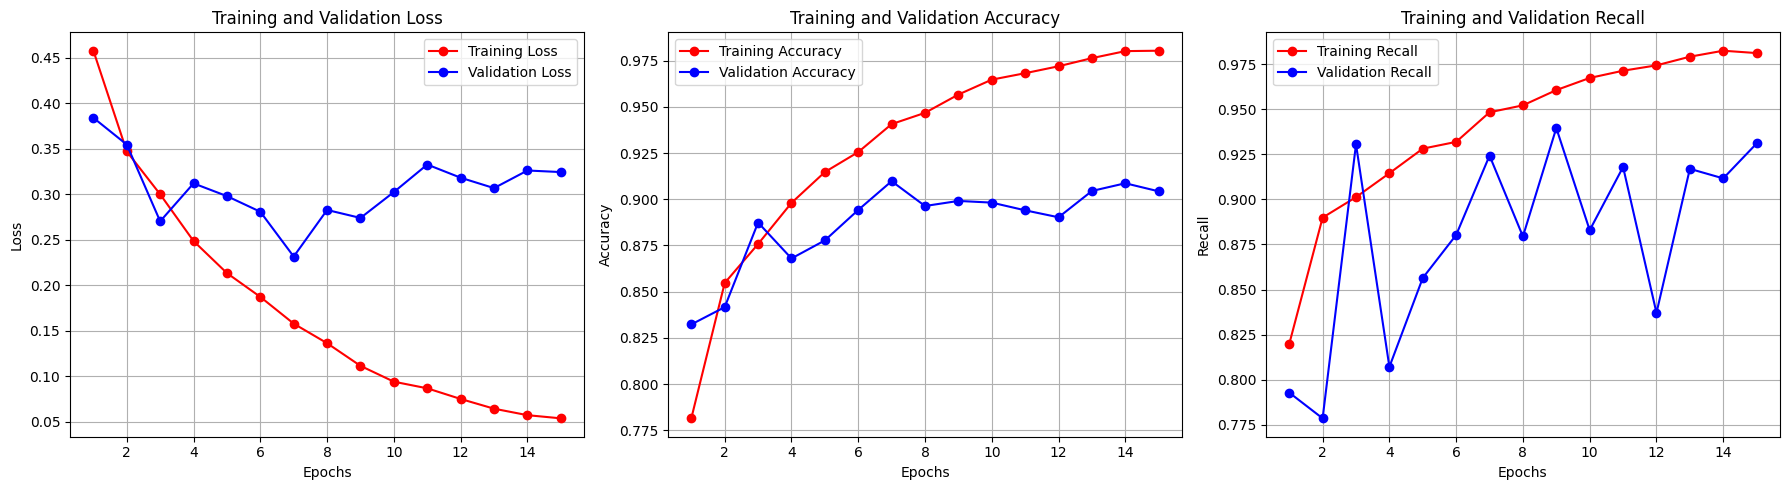

Training with parameters: {'learning_rate': 0.00047292505261613645, 'batch_size': 64, 'block_type': <class '__main__.BasicBlock'>, 'numblocks_1': 8, 'numblocks_2': 2, 'numblocks_3': 7, 'numblocks_4': 4}
epoch: 1


100%|██████████| 154/154 [00:01<00:00, 83.81it/s]


Training Loss: 0.3953, Training Accuracy: 0.8225, Training Recall for class 1 (tumor): 0.8633
Validation Loss: 0.5404, Validation Accuracy: 0.7351, Validation Recall for class 1 (tumor): 0.5138
epoch: 2


100%|██████████| 154/154 [00:01<00:00, 84.29it/s]


Training Loss: 0.2840, Training Accuracy: 0.8839, Training Recall for class 1 (tumor): 0.9053
Validation Loss: 0.3977, Validation Accuracy: 0.8094, Validation Recall for class 1 (tumor): 0.8014
epoch: 3


100%|██████████| 154/154 [00:01<00:00, 82.14it/s]


Training Loss: 0.2309, Training Accuracy: 0.9049, Training Recall for class 1 (tumor): 0.9195
Validation Loss: 0.2619, Validation Accuracy: 0.8915, Validation Recall for class 1 (tumor): 0.8735
epoch: 4


100%|██████████| 154/154 [00:01<00:00, 82.58it/s]


Training Loss: 0.1953, Training Accuracy: 0.9213, Training Recall for class 1 (tumor): 0.9293
Validation Loss: 0.3744, Validation Accuracy: 0.8626, Validation Recall for class 1 (tumor): 0.8165
epoch: 5


100%|██████████| 154/154 [00:01<00:00, 83.86it/s]


Training Loss: 0.1687, Training Accuracy: 0.9353, Training Recall for class 1 (tumor): 0.9423
Validation Loss: 0.2473, Validation Accuracy: 0.9065, Validation Recall for class 1 (tumor): 0.9462
epoch: 6


100%|██████████| 154/154 [00:01<00:00, 84.59it/s]


Training Loss: 0.1429, Training Accuracy: 0.9452, Training Recall for class 1 (tumor): 0.9496
Validation Loss: 0.2336, Validation Accuracy: 0.9081, Validation Recall for class 1 (tumor): 0.9022
epoch: 7


100%|██████████| 154/154 [00:01<00:00, 82.80it/s]


Training Loss: 0.1205, Training Accuracy: 0.9537, Training Recall for class 1 (tumor): 0.9598
Validation Loss: 0.4026, Validation Accuracy: 0.8747, Validation Recall for class 1 (tumor): 0.7933
epoch: 8


100%|██████████| 154/154 [00:01<00:00, 82.89it/s]


Training Loss: 0.0998, Training Accuracy: 0.9631, Training Recall for class 1 (tumor): 0.9663
Validation Loss: 0.2270, Validation Accuracy: 0.9214, Validation Recall for class 1 (tumor): 0.9373
epoch: 9


100%|██████████| 154/154 [00:01<00:00, 84.18it/s]


Training Loss: 0.0887, Training Accuracy: 0.9664, Training Recall for class 1 (tumor): 0.9678
Validation Loss: 1.1075, Validation Accuracy: 0.7205, Validation Recall for class 1 (tumor): 0.4560
epoch: 10


100%|██████████| 154/154 [00:01<00:00, 83.64it/s]


Training Loss: 0.0758, Training Accuracy: 0.9713, Training Recall for class 1 (tumor): 0.9726
Validation Loss: 0.2928, Validation Accuracy: 0.9189, Validation Recall for class 1 (tumor): 0.9222
epoch: 11


100%|██████████| 154/154 [00:01<00:00, 83.70it/s]


Training Loss: 0.0691, Training Accuracy: 0.9735, Training Recall for class 1 (tumor): 0.9747
Validation Loss: 0.2769, Validation Accuracy: 0.9251, Validation Recall for class 1 (tumor): 0.9497
epoch: 12


100%|██████████| 154/154 [00:01<00:00, 83.42it/s]


Training Loss: 0.0579, Training Accuracy: 0.9791, Training Recall for class 1 (tumor): 0.9805
Validation Loss: 0.2713, Validation Accuracy: 0.9114, Validation Recall for class 1 (tumor): 0.9165
epoch: 13


100%|██████████| 154/154 [00:01<00:00, 83.05it/s]


Training Loss: 0.0543, Training Accuracy: 0.9806, Training Recall for class 1 (tumor): 0.9821
Validation Loss: 0.2609, Validation Accuracy: 0.9193, Validation Recall for class 1 (tumor): 0.9026
epoch: 14


100%|██████████| 154/154 [00:01<00:00, 84.86it/s]


Training Loss: 0.0453, Training Accuracy: 0.9840, Training Recall for class 1 (tumor): 0.9846
Validation Loss: 0.3068, Validation Accuracy: 0.9232, Validation Recall for class 1 (tumor): 0.9136
epoch: 15


100%|██████████| 154/154 [00:01<00:00, 84.09it/s]


Training Loss: 0.0447, Training Accuracy: 0.9845, Training Recall for class 1 (tumor): 0.9851
Validation Loss: 0.3222, Validation Accuracy: 0.9054, Validation Recall for class 1 (tumor): 0.8782


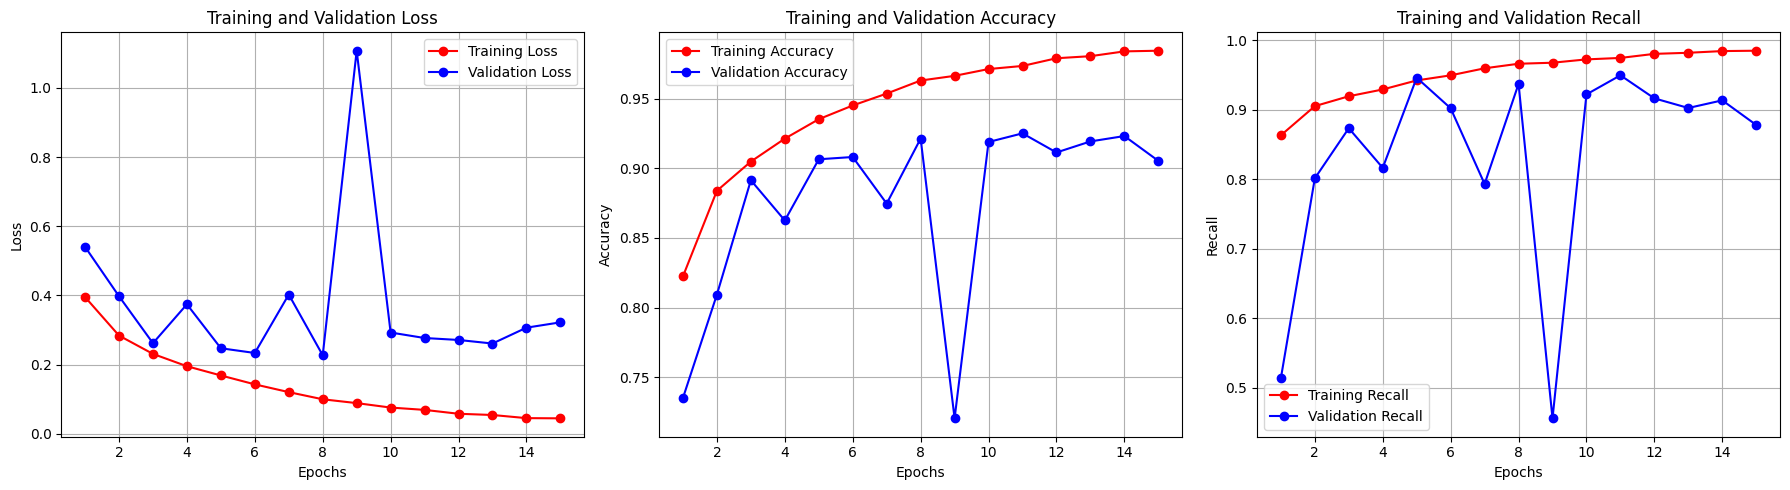

Training with parameters: {'learning_rate': 0.0039978040531536176, 'batch_size': 64, 'block_type': <class '__main__.Bottleneck'>, 'numblocks_1': 6, 'numblocks_2': 5, 'numblocks_3': 5, 'numblocks_4': 6}
epoch: 1


100%|██████████| 154/154 [00:02<00:00, 58.05it/s]


Training Loss: 0.5159, Training Accuracy: 0.7995, Training Recall for class 1 (tumor): 0.8416
Validation Loss: 0.3595, Validation Accuracy: 0.8433, Validation Recall for class 1 (tumor): 0.9436
epoch: 2


100%|██████████| 154/154 [00:02<00:00, 58.74it/s]


Training Loss: 0.3330, Training Accuracy: 0.8566, Training Recall for class 1 (tumor): 0.8922
Validation Loss: 0.3591, Validation Accuracy: 0.8396, Validation Recall for class 1 (tumor): 0.7723
epoch: 3


100%|██████████| 154/154 [00:02<00:00, 58.56it/s]


Training Loss: 0.2891, Training Accuracy: 0.8815, Training Recall for class 1 (tumor): 0.9050
Validation Loss: 0.5579, Validation Accuracy: 0.7950, Validation Recall for class 1 (tumor): 0.9888
epoch: 4


100%|██████████| 154/154 [00:02<00:00, 58.44it/s]


Training Loss: 0.2582, Training Accuracy: 0.8984, Training Recall for class 1 (tumor): 0.9178
Validation Loss: 0.3556, Validation Accuracy: 0.8344, Validation Recall for class 1 (tumor): 0.7996
epoch: 5


100%|██████████| 154/154 [00:02<00:00, 58.56it/s]


Training Loss: 0.2366, Training Accuracy: 0.9050, Training Recall for class 1 (tumor): 0.9214
Validation Loss: 1.6395, Validation Accuracy: 0.5885, Validation Recall for class 1 (tumor): 0.2138
epoch: 6


100%|██████████| 154/154 [00:02<00:00, 58.31it/s]


Training Loss: 0.2126, Training Accuracy: 0.9156, Training Recall for class 1 (tumor): 0.9301
Validation Loss: 0.7694, Validation Accuracy: 0.7389, Validation Recall for class 1 (tumor): 0.5022
epoch: 7


100%|██████████| 154/154 [00:02<00:00, 58.25it/s]


Training Loss: 0.2251, Training Accuracy: 0.9116, Training Recall for class 1 (tumor): 0.9256
Validation Loss: 0.2341, Validation Accuracy: 0.9134, Validation Recall for class 1 (tumor): 0.9625
epoch: 8


100%|██████████| 154/154 [00:02<00:00, 57.57it/s]


Training Loss: 0.1961, Training Accuracy: 0.9244, Training Recall for class 1 (tumor): 0.9337
Validation Loss: 0.2035, Validation Accuracy: 0.9253, Validation Recall for class 1 (tumor): 0.9316
epoch: 9


100%|██████████| 154/154 [00:02<00:00, 57.86it/s]


Training Loss: 0.1751, Training Accuracy: 0.9308, Training Recall for class 1 (tumor): 0.9389
Validation Loss: 1.1834, Validation Accuracy: 0.7346, Validation Recall for class 1 (tumor): 0.5102
epoch: 10


100%|██████████| 154/154 [00:02<00:00, 57.93it/s]


Training Loss: 0.1627, Training Accuracy: 0.9373, Training Recall for class 1 (tumor): 0.9467
Validation Loss: 0.3572, Validation Accuracy: 0.8679, Validation Recall for class 1 (tumor): 0.7978
epoch: 11


100%|██████████| 154/154 [00:02<00:00, 58.13it/s]


Training Loss: 0.1613, Training Accuracy: 0.9376, Training Recall for class 1 (tumor): 0.9451
Validation Loss: 0.1842, Validation Accuracy: 0.9263, Validation Recall for class 1 (tumor): 0.9395
epoch: 12


100%|██████████| 154/154 [00:03<00:00, 45.58it/s]


Training Loss: 0.1462, Training Accuracy: 0.9447, Training Recall for class 1 (tumor): 0.9499
Validation Loss: 0.3265, Validation Accuracy: 0.8655, Validation Recall for class 1 (tumor): 0.7762
epoch: 13


100%|██████████| 154/154 [00:02<00:00, 59.60it/s]


Training Loss: 0.1401, Training Accuracy: 0.9484, Training Recall for class 1 (tumor): 0.9543
Validation Loss: 0.4227, Validation Accuracy: 0.8517, Validation Recall for class 1 (tumor): 0.7986
epoch: 14


100%|██████████| 154/154 [00:02<00:00, 53.08it/s]


Training Loss: 0.1256, Training Accuracy: 0.9547, Training Recall for class 1 (tumor): 0.9606
Validation Loss: 0.6812, Validation Accuracy: 0.8294, Validation Recall for class 1 (tumor): 0.7104
epoch: 15


100%|██████████| 154/154 [00:02<00:00, 52.09it/s]


Training Loss: 0.1312, Training Accuracy: 0.9490, Training Recall for class 1 (tumor): 0.9553
Validation Loss: 0.4526, Validation Accuracy: 0.8439, Validation Recall for class 1 (tumor): 0.7387


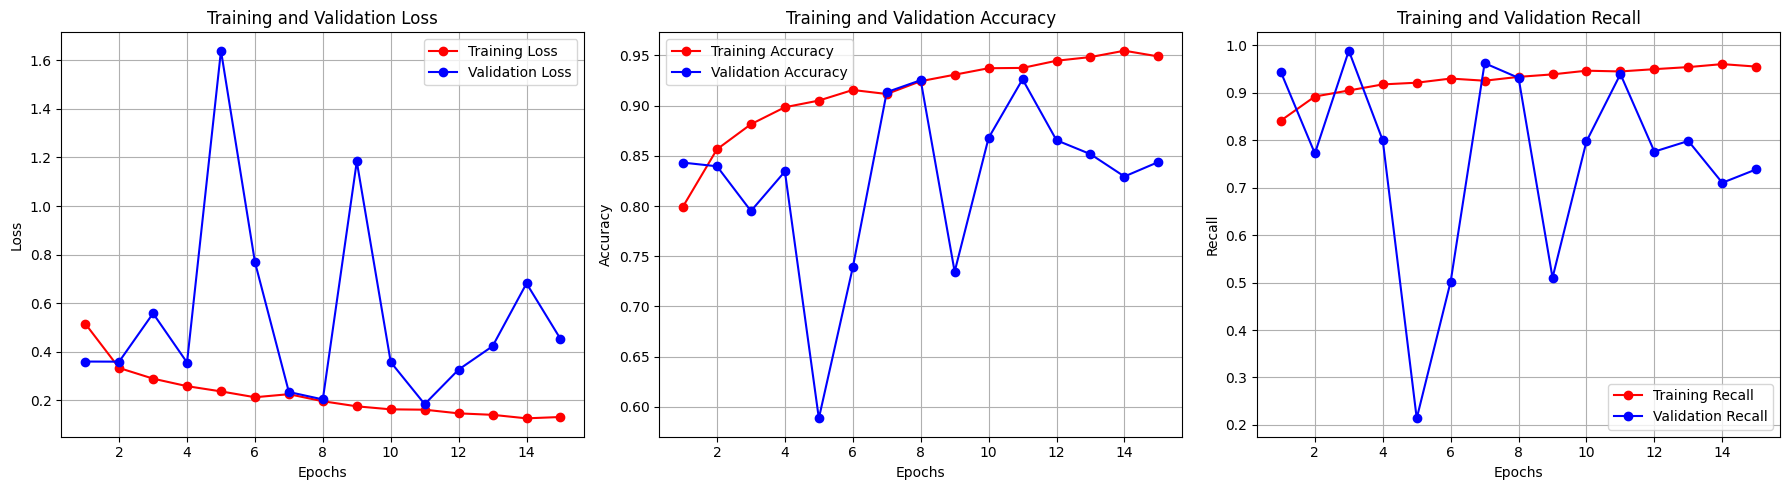

Training with parameters: {'learning_rate': 0.00016286029396902517, 'batch_size': 32, 'block_type': <class '__main__.BasicBlock'>, 'numblocks_1': 6, 'numblocks_2': 3, 'numblocks_3': 2, 'numblocks_4': 3}
epoch: 1


100%|██████████| 308/308 [00:02<00:00, 109.45it/s]


Training Loss: 0.4032, Training Accuracy: 0.8159, Training Recall for class 1 (tumor): 0.8459
Validation Loss: 0.5680, Validation Accuracy: 0.7494, Validation Recall for class 1 (tumor): 0.9705
epoch: 2


100%|██████████| 308/308 [00:02<00:00, 110.34it/s]


Training Loss: 0.3028, Training Accuracy: 0.8722, Training Recall for class 1 (tumor): 0.9004
Validation Loss: 0.2901, Validation Accuracy: 0.8760, Validation Recall for class 1 (tumor): 0.9385
epoch: 3


100%|██████████| 308/308 [00:02<00:00, 109.70it/s]


Training Loss: 0.2444, Training Accuracy: 0.9002, Training Recall for class 1 (tumor): 0.9183
Validation Loss: 0.3376, Validation Accuracy: 0.8853, Validation Recall for class 1 (tumor): 0.8990
epoch: 4


100%|██████████| 308/308 [00:02<00:00, 109.83it/s]


Training Loss: 0.2012, Training Accuracy: 0.9204, Training Recall for class 1 (tumor): 0.9352
Validation Loss: 0.2710, Validation Accuracy: 0.8838, Validation Recall for class 1 (tumor): 0.9367
epoch: 5


100%|██████████| 308/308 [00:02<00:00, 108.60it/s]


Training Loss: 0.1642, Training Accuracy: 0.9362, Training Recall for class 1 (tumor): 0.9428
Validation Loss: 0.3410, Validation Accuracy: 0.8698, Validation Recall for class 1 (tumor): 0.9642
epoch: 6


100%|██████████| 308/308 [00:02<00:00, 109.66it/s]


Training Loss: 0.1377, Training Accuracy: 0.9464, Training Recall for class 1 (tumor): 0.9528
Validation Loss: 0.2478, Validation Accuracy: 0.9121, Validation Recall for class 1 (tumor): 0.9000
epoch: 7


100%|██████████| 308/308 [00:02<00:00, 110.92it/s]


Training Loss: 0.1076, Training Accuracy: 0.9594, Training Recall for class 1 (tumor): 0.9626
Validation Loss: 0.2756, Validation Accuracy: 0.9057, Validation Recall for class 1 (tumor): 0.8876
epoch: 8


100%|██████████| 308/308 [00:02<00:00, 112.36it/s]


Training Loss: 0.0946, Training Accuracy: 0.9632, Training Recall for class 1 (tumor): 0.9671
Validation Loss: 0.3511, Validation Accuracy: 0.8826, Validation Recall for class 1 (tumor): 0.9593
epoch: 9


100%|██████████| 308/308 [00:02<00:00, 109.80it/s]


Training Loss: 0.0765, Training Accuracy: 0.9704, Training Recall for class 1 (tumor): 0.9732
Validation Loss: 0.3006, Validation Accuracy: 0.9006, Validation Recall for class 1 (tumor): 0.9576
epoch: 10


100%|██████████| 308/308 [00:02<00:00, 111.76it/s]


Training Loss: 0.0642, Training Accuracy: 0.9769, Training Recall for class 1 (tumor): 0.9784
Validation Loss: 0.2677, Validation Accuracy: 0.9035, Validation Recall for class 1 (tumor): 0.8807
epoch: 11


100%|██████████| 308/308 [00:02<00:00, 110.82it/s]


Training Loss: 0.0613, Training Accuracy: 0.9776, Training Recall for class 1 (tumor): 0.9788
Validation Loss: 0.3030, Validation Accuracy: 0.9062, Validation Recall for class 1 (tumor): 0.9462
epoch: 12


100%|██████████| 308/308 [00:02<00:00, 112.69it/s]


Training Loss: 0.0552, Training Accuracy: 0.9792, Training Recall for class 1 (tumor): 0.9805
Validation Loss: 0.3318, Validation Accuracy: 0.9151, Validation Recall for class 1 (tumor): 0.9308
epoch: 13


100%|██████████| 308/308 [00:02<00:00, 111.69it/s]


Training Loss: 0.0522, Training Accuracy: 0.9806, Training Recall for class 1 (tumor): 0.9823
Validation Loss: 0.3480, Validation Accuracy: 0.9109, Validation Recall for class 1 (tumor): 0.9452
epoch: 14


100%|██████████| 308/308 [00:02<00:00, 111.90it/s]


Training Loss: 0.0405, Training Accuracy: 0.9853, Training Recall for class 1 (tumor): 0.9854
Validation Loss: 0.5321, Validation Accuracy: 0.8407, Validation Recall for class 1 (tumor): 0.7022
epoch: 15


100%|██████████| 308/308 [00:02<00:00, 107.21it/s]


Training Loss: 0.0406, Training Accuracy: 0.9849, Training Recall for class 1 (tumor): 0.9852
Validation Loss: 0.2800, Validation Accuracy: 0.9126, Validation Recall for class 1 (tumor): 0.9318


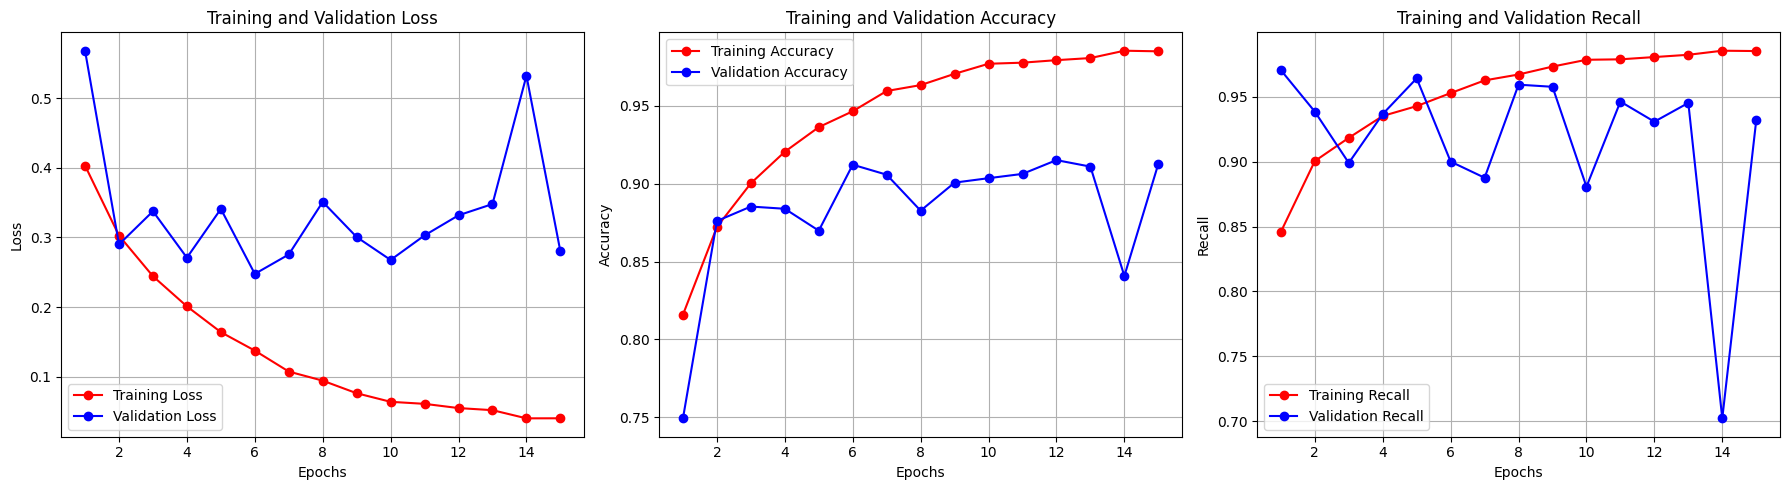

Training with parameters: {'learning_rate': 0.00019922770602188438, 'batch_size': 32, 'block_type': <class '__main__.BasicBlock'>, 'numblocks_1': 7, 'numblocks_2': 4, 'numblocks_3': 5, 'numblocks_4': 7}
epoch: 1


100%|██████████| 308/308 [00:03<00:00, 81.66it/s]


Training Loss: 0.4326, Training Accuracy: 0.7982, Training Recall for class 1 (tumor): 0.8326
Validation Loss: 0.3247, Validation Accuracy: 0.8610, Validation Recall for class 1 (tumor): 0.8615
epoch: 2


100%|██████████| 308/308 [00:03<00:00, 83.74it/s]


Training Loss: 0.3196, Training Accuracy: 0.8658, Training Recall for class 1 (tumor): 0.8896
Validation Loss: 0.3089, Validation Accuracy: 0.8660, Validation Recall for class 1 (tumor): 0.8220
epoch: 3


100%|██████████| 308/308 [00:03<00:00, 81.30it/s]


Training Loss: 0.2631, Training Accuracy: 0.8924, Training Recall for class 1 (tumor): 0.9082
Validation Loss: 0.2910, Validation Accuracy: 0.8748, Validation Recall for class 1 (tumor): 0.9662
epoch: 4


100%|██████████| 308/308 [00:03<00:00, 82.19it/s]


Training Loss: 0.2209, Training Accuracy: 0.9101, Training Recall for class 1 (tumor): 0.9209
Validation Loss: 0.4397, Validation Accuracy: 0.8115, Validation Recall for class 1 (tumor): 0.6939
epoch: 5


100%|██████████| 308/308 [00:03<00:00, 83.75it/s]


Training Loss: 0.1915, Training Accuracy: 0.9245, Training Recall for class 1 (tumor): 0.9332
Validation Loss: 0.2204, Validation Accuracy: 0.9138, Validation Recall for class 1 (tumor): 0.9316
epoch: 6


100%|██████████| 308/308 [00:03<00:00, 81.94it/s]


Training Loss: 0.1720, Training Accuracy: 0.9323, Training Recall for class 1 (tumor): 0.9378
Validation Loss: 0.2374, Validation Accuracy: 0.9068, Validation Recall for class 1 (tumor): 0.8894
epoch: 7


100%|██████████| 308/308 [00:03<00:00, 81.16it/s]


Training Loss: 0.1489, Training Accuracy: 0.9419, Training Recall for class 1 (tumor): 0.9465
Validation Loss: 0.3034, Validation Accuracy: 0.8816, Validation Recall for class 1 (tumor): 0.9737
epoch: 8


100%|██████████| 308/308 [00:03<00:00, 80.55it/s]


Training Loss: 0.1264, Training Accuracy: 0.9524, Training Recall for class 1 (tumor): 0.9556
Validation Loss: 0.2549, Validation Accuracy: 0.9095, Validation Recall for class 1 (tumor): 0.9275
epoch: 9


100%|██████████| 308/308 [00:03<00:00, 81.16it/s]


Training Loss: 0.1080, Training Accuracy: 0.9596, Training Recall for class 1 (tumor): 0.9632
Validation Loss: 0.2408, Validation Accuracy: 0.9097, Validation Recall for class 1 (tumor): 0.9279
epoch: 10


100%|██████████| 308/308 [00:03<00:00, 79.94it/s]


Training Loss: 0.0905, Training Accuracy: 0.9669, Training Recall for class 1 (tumor): 0.9668
Validation Loss: 0.2575, Validation Accuracy: 0.9094, Validation Recall for class 1 (tumor): 0.8625
epoch: 11


100%|██████████| 308/308 [00:03<00:00, 82.92it/s]


Training Loss: 0.0881, Training Accuracy: 0.9671, Training Recall for class 1 (tumor): 0.9683
Validation Loss: 0.2290, Validation Accuracy: 0.9198, Validation Recall for class 1 (tumor): 0.9098
epoch: 12


100%|██████████| 308/308 [00:03<00:00, 84.33it/s]


Training Loss: 0.0679, Training Accuracy: 0.9745, Training Recall for class 1 (tumor): 0.9750
Validation Loss: 0.3096, Validation Accuracy: 0.9097, Validation Recall for class 1 (tumor): 0.9448
epoch: 13


100%|██████████| 308/308 [00:03<00:00, 82.32it/s]


Training Loss: 0.0635, Training Accuracy: 0.9775, Training Recall for class 1 (tumor): 0.9781
Validation Loss: 0.3535, Validation Accuracy: 0.8930, Validation Recall for class 1 (tumor): 0.8360
epoch: 14


100%|██████████| 308/308 [00:03<00:00, 82.69it/s]


Training Loss: 0.0595, Training Accuracy: 0.9781, Training Recall for class 1 (tumor): 0.9799
Validation Loss: 0.2661, Validation Accuracy: 0.9188, Validation Recall for class 1 (tumor): 0.9281
epoch: 15


100%|██████████| 308/308 [00:03<00:00, 81.30it/s]


Training Loss: 0.0557, Training Accuracy: 0.9799, Training Recall for class 1 (tumor): 0.9802
Validation Loss: 0.3030, Validation Accuracy: 0.9036, Validation Recall for class 1 (tumor): 0.8530


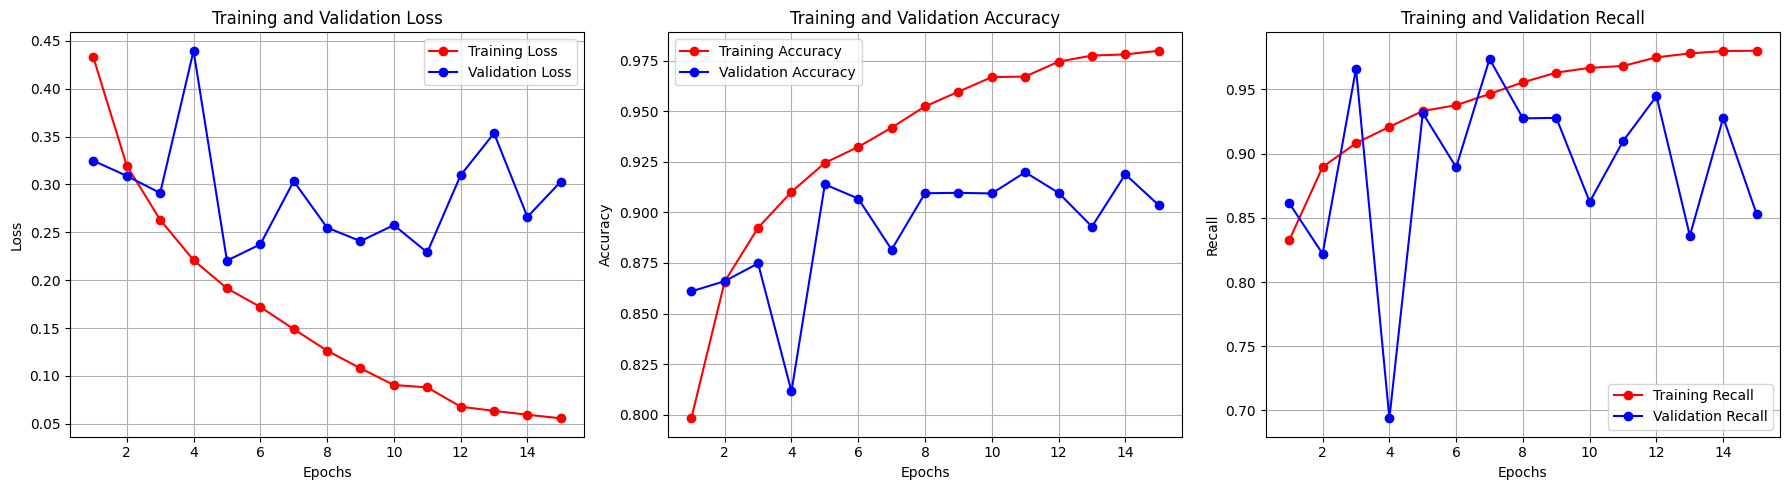

Training with parameters: {'learning_rate': 0.00015796493776417485, 'batch_size': 128, 'block_type': <class '__main__.Bottleneck'>, 'numblocks_1': 2, 'numblocks_2': 4, 'numblocks_3': 6, 'numblocks_4': 5}
epoch: 1


100%|██████████| 77/77 [00:01<00:00, 43.28it/s]


Training Loss: 0.5221, Training Accuracy: 0.7333, Training Recall for class 1 (tumor): 0.7641
Validation Loss: 0.5629, Validation Accuracy: 0.7113, Validation Recall for class 1 (tumor): 0.9664
epoch: 2


100%|██████████| 77/77 [00:01<00:00, 43.00it/s]


Training Loss: 0.4357, Training Accuracy: 0.7945, Training Recall for class 1 (tumor): 0.8256
Validation Loss: 0.4416, Validation Accuracy: 0.7940, Validation Recall for class 1 (tumor): 0.9024
epoch: 3


100%|██████████| 77/77 [00:01<00:00, 43.37it/s]


Training Loss: 0.3863, Training Accuracy: 0.8287, Training Recall for class 1 (tumor): 0.8674
Validation Loss: 0.4321, Validation Accuracy: 0.8102, Validation Recall for class 1 (tumor): 0.7438
epoch: 4


100%|██████████| 77/77 [00:01<00:00, 43.57it/s]


Training Loss: 0.3481, Training Accuracy: 0.8494, Training Recall for class 1 (tumor): 0.8853
Validation Loss: 0.3947, Validation Accuracy: 0.8252, Validation Recall for class 1 (tumor): 0.9308
epoch: 5


100%|██████████| 77/77 [00:01<00:00, 43.05it/s]


Training Loss: 0.3078, Training Accuracy: 0.8720, Training Recall for class 1 (tumor): 0.8989
Validation Loss: 0.3861, Validation Accuracy: 0.8363, Validation Recall for class 1 (tumor): 0.7974
epoch: 6


100%|██████████| 77/77 [00:01<00:00, 42.44it/s]


Training Loss: 0.2729, Training Accuracy: 0.8892, Training Recall for class 1 (tumor): 0.9132
Validation Loss: 0.4240, Validation Accuracy: 0.8300, Validation Recall for class 1 (tumor): 0.7259
epoch: 7


100%|██████████| 77/77 [00:01<00:00, 42.84it/s]


Training Loss: 0.2477, Training Accuracy: 0.8985, Training Recall for class 1 (tumor): 0.9186
Validation Loss: 0.3072, Validation Accuracy: 0.8729, Validation Recall for class 1 (tumor): 0.9000
epoch: 8


100%|██████████| 77/77 [00:01<00:00, 43.41it/s]


Training Loss: 0.2228, Training Accuracy: 0.9092, Training Recall for class 1 (tumor): 0.9246
Validation Loss: 0.3403, Validation Accuracy: 0.8687, Validation Recall for class 1 (tumor): 0.9513
epoch: 9


100%|██████████| 77/77 [00:01<00:00, 43.01it/s]


Training Loss: 0.2028, Training Accuracy: 0.9189, Training Recall for class 1 (tumor): 0.9317
Validation Loss: 0.3425, Validation Accuracy: 0.8620, Validation Recall for class 1 (tumor): 0.8075
epoch: 10


100%|██████████| 77/77 [00:01<00:00, 42.97it/s]


Training Loss: 0.1749, Training Accuracy: 0.9299, Training Recall for class 1 (tumor): 0.9421
Validation Loss: 0.5675, Validation Accuracy: 0.8043, Validation Recall for class 1 (tumor): 0.6695
epoch: 11


100%|██████████| 77/77 [00:01<00:00, 43.26it/s]


Training Loss: 0.1622, Training Accuracy: 0.9367, Training Recall for class 1 (tumor): 0.9458
Validation Loss: 0.3135, Validation Accuracy: 0.8698, Validation Recall for class 1 (tumor): 0.8468
epoch: 12


100%|██████████| 77/77 [00:01<00:00, 43.01it/s]


Training Loss: 0.1504, Training Accuracy: 0.9407, Training Recall for class 1 (tumor): 0.9479
Validation Loss: 0.3318, Validation Accuracy: 0.8934, Validation Recall for class 1 (tumor): 0.8825
epoch: 13


100%|██████████| 77/77 [00:01<00:00, 43.41it/s]


Training Loss: 0.1282, Training Accuracy: 0.9502, Training Recall for class 1 (tumor): 0.9554
Validation Loss: 0.2997, Validation Accuracy: 0.8940, Validation Recall for class 1 (tumor): 0.9183
epoch: 14


100%|██████████| 77/77 [00:01<00:00, 43.35it/s]


Training Loss: 0.1126, Training Accuracy: 0.9561, Training Recall for class 1 (tumor): 0.9598
Validation Loss: 0.3331, Validation Accuracy: 0.8797, Validation Recall for class 1 (tumor): 0.8593
epoch: 15


100%|██████████| 77/77 [00:01<00:00, 42.90it/s]


Training Loss: 0.1121, Training Accuracy: 0.9580, Training Recall for class 1 (tumor): 0.9619
Validation Loss: 0.4242, Validation Accuracy: 0.8462, Validation Recall for class 1 (tumor): 0.8607


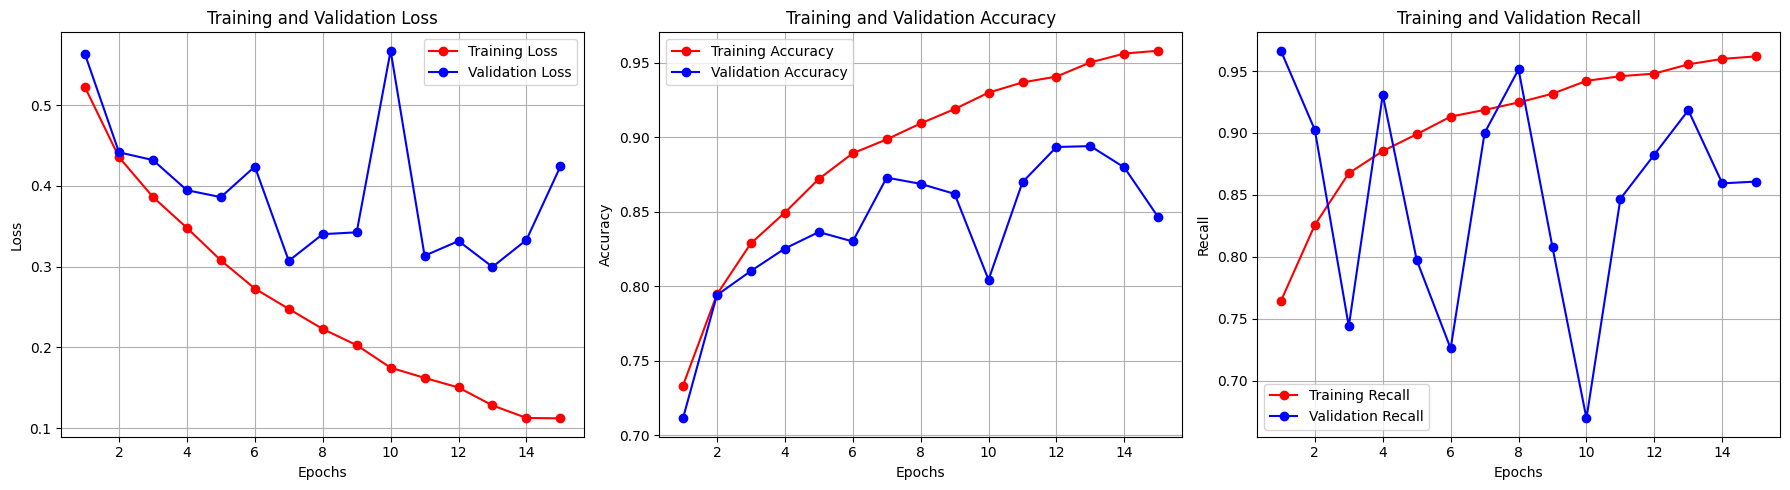

Training with parameters: {'learning_rate': 0.00044678075533567343, 'batch_size': 16, 'block_type': <class '__main__.Bottleneck'>, 'numblocks_1': 8, 'numblocks_2': 6, 'numblocks_3': 5, 'numblocks_4': 8}
epoch: 1


100%|██████████| 615/615 [00:11<00:00, 53.30it/s]


Training Loss: 0.5432, Training Accuracy: 0.7373, Training Recall for class 1 (tumor): 0.7574
Validation Loss: 0.4111, Validation Accuracy: 0.8144, Validation Recall for class 1 (tumor): 0.8024
epoch: 2


100%|██████████| 615/615 [00:11<00:00, 52.46it/s]


Training Loss: 0.4351, Training Accuracy: 0.8024, Training Recall for class 1 (tumor): 0.8402
Validation Loss: 0.3717, Validation Accuracy: 0.8447, Validation Recall for class 1 (tumor): 0.9108
epoch: 3


100%|██████████| 615/615 [00:11<00:00, 53.94it/s]


Training Loss: 0.4003, Training Accuracy: 0.8237, Training Recall for class 1 (tumor): 0.8636
Validation Loss: 0.3684, Validation Accuracy: 0.8476, Validation Recall for class 1 (tumor): 0.9411
epoch: 4


100%|██████████| 615/615 [00:11<00:00, 54.80it/s]


Training Loss: 0.3712, Training Accuracy: 0.8363, Training Recall for class 1 (tumor): 0.8715
Validation Loss: 0.3416, Validation Accuracy: 0.8531, Validation Recall for class 1 (tumor): 0.9670
epoch: 5


100%|██████████| 615/615 [00:11<00:00, 53.77it/s]


Training Loss: 0.3408, Training Accuracy: 0.8572, Training Recall for class 1 (tumor): 0.8881
Validation Loss: 0.3512, Validation Accuracy: 0.8387, Validation Recall for class 1 (tumor): 0.7397
epoch: 6


100%|██████████| 615/615 [00:11<00:00, 52.26it/s]


Training Loss: 0.3136, Training Accuracy: 0.8663, Training Recall for class 1 (tumor): 0.8942
Validation Loss: 0.3072, Validation Accuracy: 0.8690, Validation Recall for class 1 (tumor): 0.8725
epoch: 7


100%|██████████| 615/615 [00:11<00:00, 54.34it/s]


Training Loss: 0.2897, Training Accuracy: 0.8793, Training Recall for class 1 (tumor): 0.9025
Validation Loss: 0.2671, Validation Accuracy: 0.8866, Validation Recall for class 1 (tumor): 0.8688
epoch: 8


100%|██████████| 615/615 [00:12<00:00, 51.21it/s]


Training Loss: 0.2661, Training Accuracy: 0.8909, Training Recall for class 1 (tumor): 0.9087
Validation Loss: 0.2764, Validation Accuracy: 0.8855, Validation Recall for class 1 (tumor): 0.8890
epoch: 9


100%|██████████| 615/615 [00:11<00:00, 53.42it/s]


Training Loss: 0.2345, Training Accuracy: 0.9038, Training Recall for class 1 (tumor): 0.9181
Validation Loss: 0.2434, Validation Accuracy: 0.9029, Validation Recall for class 1 (tumor): 0.9413
epoch: 10


100%|██████████| 615/615 [00:11<00:00, 54.22it/s]


Training Loss: 0.2135, Training Accuracy: 0.9142, Training Recall for class 1 (tumor): 0.9296
Validation Loss: 0.2311, Validation Accuracy: 0.9099, Validation Recall for class 1 (tumor): 0.9002
epoch: 11


100%|██████████| 615/615 [00:11<00:00, 52.76it/s]


Training Loss: 0.1905, Training Accuracy: 0.9259, Training Recall for class 1 (tumor): 0.9363
Validation Loss: 0.2005, Validation Accuracy: 0.9202, Validation Recall for class 1 (tumor): 0.8996
epoch: 12


100%|██████████| 615/615 [00:11<00:00, 53.98it/s]


Training Loss: 0.1710, Training Accuracy: 0.9327, Training Recall for class 1 (tumor): 0.9413
Validation Loss: 0.2054, Validation Accuracy: 0.9188, Validation Recall for class 1 (tumor): 0.9126
epoch: 13


100%|██████████| 615/615 [00:11<00:00, 54.42it/s]


Training Loss: 0.1556, Training Accuracy: 0.9382, Training Recall for class 1 (tumor): 0.9464
Validation Loss: 0.1947, Validation Accuracy: 0.9304, Validation Recall for class 1 (tumor): 0.9652
epoch: 14


100%|██████████| 615/615 [00:11<00:00, 52.91it/s]


Training Loss: 0.1363, Training Accuracy: 0.9481, Training Recall for class 1 (tumor): 0.9523
Validation Loss: 0.1687, Validation Accuracy: 0.9357, Validation Recall for class 1 (tumor): 0.9458
epoch: 15


100%|██████████| 615/615 [00:11<00:00, 54.09it/s]


Training Loss: 0.1198, Training Accuracy: 0.9536, Training Recall for class 1 (tumor): 0.9578
Validation Loss: 0.1872, Validation Accuracy: 0.9256, Validation Recall for class 1 (tumor): 0.9430


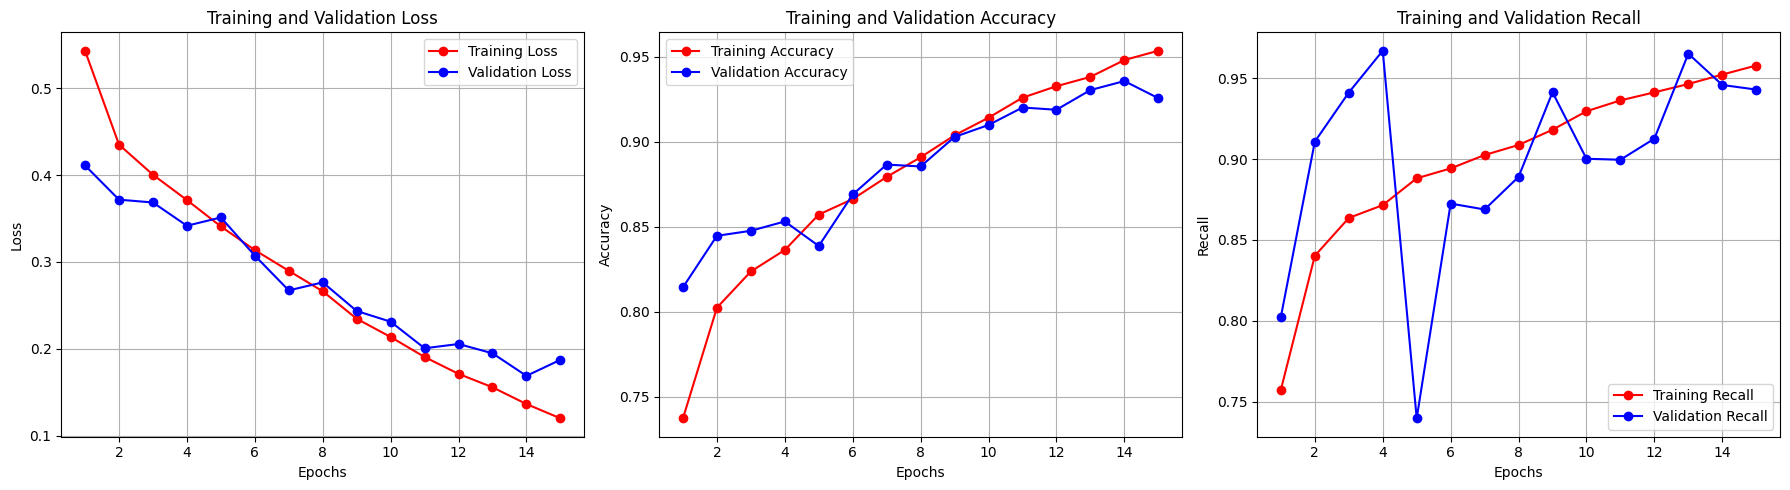

Training with parameters: {'learning_rate': 0.0014578091067267067, 'batch_size': 32, 'block_type': <class '__main__.BasicBlock'>, 'numblocks_1': 5, 'numblocks_2': 3, 'numblocks_3': 6, 'numblocks_4': 3}
epoch: 1


100%|██████████| 308/308 [00:03<00:00, 98.92it/s] 


Training Loss: 0.4238, Training Accuracy: 0.8086, Training Recall for class 1 (tumor): 0.8457
Validation Loss: 0.3406, Validation Accuracy: 0.8484, Validation Recall for class 1 (tumor): 0.9301
epoch: 2


100%|██████████| 308/308 [00:03<00:00, 97.12it/s] 


Training Loss: 0.3400, Training Accuracy: 0.8570, Training Recall for class 1 (tumor): 0.8875
Validation Loss: 0.4609, Validation Accuracy: 0.7911, Validation Recall for class 1 (tumor): 0.6316
epoch: 3


100%|██████████| 308/308 [00:03<00:00, 96.97it/s]


Training Loss: 0.3033, Training Accuracy: 0.8750, Training Recall for class 1 (tumor): 0.8968
Validation Loss: 0.4756, Validation Accuracy: 0.7895, Validation Recall for class 1 (tumor): 0.9619
epoch: 4


100%|██████████| 308/308 [00:03<00:00, 95.24it/s] 


Training Loss: 0.2591, Training Accuracy: 0.8956, Training Recall for class 1 (tumor): 0.9102
Validation Loss: 0.6371, Validation Accuracy: 0.7690, Validation Recall for class 1 (tumor): 0.5631
epoch: 5


100%|██████████| 308/308 [00:03<00:00, 100.05it/s]


Training Loss: 0.2308, Training Accuracy: 0.9061, Training Recall for class 1 (tumor): 0.9208
Validation Loss: 0.8388, Validation Accuracy: 0.6901, Validation Recall for class 1 (tumor): 0.3978
epoch: 6


100%|██████████| 308/308 [00:03<00:00, 93.65it/s]


Training Loss: 0.2035, Training Accuracy: 0.9204, Training Recall for class 1 (tumor): 0.9326
Validation Loss: 0.4234, Validation Accuracy: 0.8347, Validation Recall for class 1 (tumor): 0.7460
epoch: 7


100%|██████████| 308/308 [00:03<00:00, 99.65it/s] 


Training Loss: 0.1872, Training Accuracy: 0.9278, Training Recall for class 1 (tumor): 0.9377
Validation Loss: 0.2331, Validation Accuracy: 0.8999, Validation Recall for class 1 (tumor): 0.8621
epoch: 8


100%|██████████| 308/308 [00:03<00:00, 100.64it/s]


Training Loss: 0.1644, Training Accuracy: 0.9350, Training Recall for class 1 (tumor): 0.9431
Validation Loss: 0.8751, Validation Accuracy: 0.8085, Validation Recall for class 1 (tumor): 0.9878
epoch: 9


100%|██████████| 308/308 [00:03<00:00, 98.23it/s] 


Training Loss: 0.1522, Training Accuracy: 0.9408, Training Recall for class 1 (tumor): 0.9485
Validation Loss: 0.2330, Validation Accuracy: 0.9088, Validation Recall for class 1 (tumor): 0.8460
epoch: 10


100%|██████████| 308/308 [00:03<00:00, 93.42it/s]


Training Loss: 0.1347, Training Accuracy: 0.9486, Training Recall for class 1 (tumor): 0.9544
Validation Loss: 1.5493, Validation Accuracy: 0.7098, Validation Recall for class 1 (tumor): 0.4354
epoch: 11


100%|██████████| 308/308 [00:03<00:00, 96.34it/s]


Training Loss: 0.1228, Training Accuracy: 0.9540, Training Recall for class 1 (tumor): 0.9588
Validation Loss: 0.4877, Validation Accuracy: 0.8290, Validation Recall for class 1 (tumor): 0.6752
epoch: 12


100%|██████████| 308/308 [00:03<00:00, 99.51it/s] 


Training Loss: 0.1098, Training Accuracy: 0.9577, Training Recall for class 1 (tumor): 0.9616
Validation Loss: 0.3608, Validation Accuracy: 0.8779, Validation Recall for class 1 (tumor): 0.9906
epoch: 13


100%|██████████| 308/308 [00:03<00:00, 100.59it/s]


Training Loss: 0.0991, Training Accuracy: 0.9624, Training Recall for class 1 (tumor): 0.9649
Validation Loss: 0.2126, Validation Accuracy: 0.9240, Validation Recall for class 1 (tumor): 0.9120
epoch: 14


100%|██████████| 308/308 [00:03<00:00, 86.00it/s]


Training Loss: 0.0864, Training Accuracy: 0.9673, Training Recall for class 1 (tumor): 0.9709
Validation Loss: 0.3010, Validation Accuracy: 0.8988, Validation Recall for class 1 (tumor): 0.9263
epoch: 15


100%|██████████| 308/308 [00:03<00:00, 99.59it/s] 


Training Loss: 0.0767, Training Accuracy: 0.9694, Training Recall for class 1 (tumor): 0.9712
Validation Loss: 0.1437, Validation Accuracy: 0.9503, Validation Recall for class 1 (tumor): 0.9597


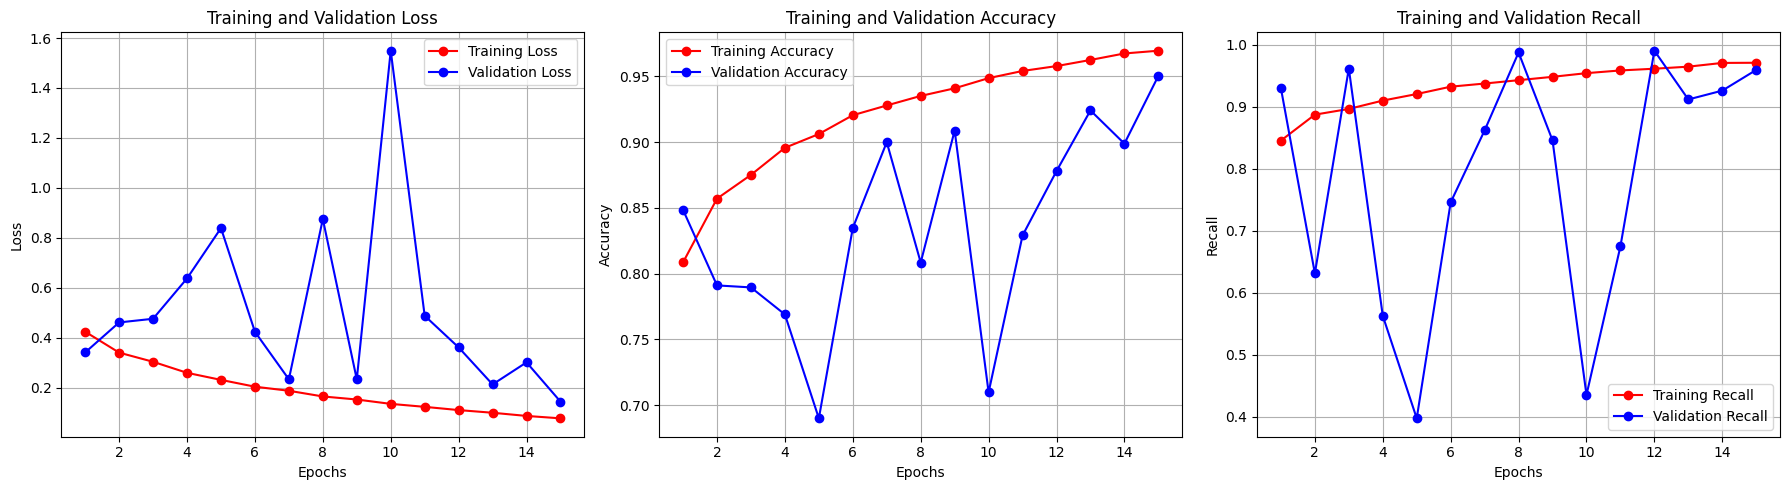

Training with parameters: {'learning_rate': 0.003603221531731875, 'batch_size': 128, 'block_type': <class '__main__.Bottleneck'>, 'numblocks_1': 1, 'numblocks_2': 5, 'numblocks_3': 6, 'numblocks_4': 8}
epoch: 1


100%|██████████| 77/77 [00:01<00:00, 39.38it/s]


Training Loss: 0.5629, Training Accuracy: 0.7809, Training Recall for class 1 (tumor): 0.8153
Validation Loss: 0.4724, Validation Accuracy: 0.8468, Validation Recall for class 1 (tumor): 0.8904
epoch: 2


100%|██████████| 77/77 [00:01<00:00, 39.74it/s]


Training Loss: 0.3371, Training Accuracy: 0.8583, Training Recall for class 1 (tumor): 0.8989
Validation Loss: 0.2882, Validation Accuracy: 0.8854, Validation Recall for class 1 (tumor): 0.8813
epoch: 3


100%|██████████| 77/77 [00:01<00:00, 39.74it/s]


Training Loss: 0.2853, Training Accuracy: 0.8843, Training Recall for class 1 (tumor): 0.9179
Validation Loss: 0.5537, Validation Accuracy: 0.7703, Validation Recall for class 1 (tumor): 0.6365
epoch: 4


100%|██████████| 77/77 [00:01<00:00, 39.49it/s]


Training Loss: 0.2403, Training Accuracy: 0.9021, Training Recall for class 1 (tumor): 0.9229
Validation Loss: 0.2745, Validation Accuracy: 0.8919, Validation Recall for class 1 (tumor): 0.9141
epoch: 5


100%|██████████| 77/77 [00:01<00:00, 39.65it/s]


Training Loss: 0.2229, Training Accuracy: 0.9129, Training Recall for class 1 (tumor): 0.9315
Validation Loss: 0.8453, Validation Accuracy: 0.7342, Validation Recall for class 1 (tumor): 0.4998
epoch: 6


100%|██████████| 77/77 [00:02<00:00, 38.00it/s]


Training Loss: 0.2182, Training Accuracy: 0.9149, Training Recall for class 1 (tumor): 0.9319
Validation Loss: 0.2305, Validation Accuracy: 0.9112, Validation Recall for class 1 (tumor): 0.9175
epoch: 7


100%|██████████| 77/77 [00:01<00:00, 39.00it/s]


Training Loss: 0.4045, Training Accuracy: 0.8495, Training Recall for class 1 (tumor): 0.8913
Validation Loss: 2.5904, Validation Accuracy: 0.5258, Validation Recall for class 1 (tumor): 0.0511
epoch: 8


100%|██████████| 77/77 [00:01<00:00, 39.81it/s]


Training Loss: 0.3959, Training Accuracy: 0.8155, Training Recall for class 1 (tumor): 0.8658
Validation Loss: 0.3318, Validation Accuracy: 0.8624, Validation Recall for class 1 (tumor): 0.9246
epoch: 9


100%|██████████| 77/77 [00:01<00:00, 39.05it/s]


Training Loss: 0.3113, Training Accuracy: 0.8713, Training Recall for class 1 (tumor): 0.9133
Validation Loss: 0.2883, Validation Accuracy: 0.8817, Validation Recall for class 1 (tumor): 0.8692
epoch: 10


100%|██████████| 77/77 [00:01<00:00, 39.37it/s]


Training Loss: 0.2617, Training Accuracy: 0.8961, Training Recall for class 1 (tumor): 0.9240
Validation Loss: 0.3687, Validation Accuracy: 0.8532, Validation Recall for class 1 (tumor): 0.7784
epoch: 11


100%|██████████| 77/77 [00:02<00:00, 38.30it/s]


Training Loss: 0.2252, Training Accuracy: 0.9110, Training Recall for class 1 (tumor): 0.9312
Validation Loss: 0.4401, Validation Accuracy: 0.8553, Validation Recall for class 1 (tumor): 0.9690
epoch: 12


100%|██████████| 77/77 [00:01<00:00, 39.42it/s]


Training Loss: 0.1972, Training Accuracy: 0.9229, Training Recall for class 1 (tumor): 0.9419
Validation Loss: 0.3852, Validation Accuracy: 0.8421, Validation Recall for class 1 (tumor): 0.7269
epoch: 13


100%|██████████| 77/77 [00:01<00:00, 39.70it/s]


Training Loss: 0.1778, Training Accuracy: 0.9324, Training Recall for class 1 (tumor): 0.9465
Validation Loss: 0.2695, Validation Accuracy: 0.8885, Validation Recall for class 1 (tumor): 0.8992
epoch: 14


100%|██████████| 77/77 [00:01<00:00, 39.63it/s]


Training Loss: 0.1563, Training Accuracy: 0.9401, Training Recall for class 1 (tumor): 0.9508
Validation Loss: 1.2261, Validation Accuracy: 0.7070, Validation Recall for class 1 (tumor): 0.4452
epoch: 15


100%|██████████| 77/77 [00:01<00:00, 39.61it/s]


Training Loss: 0.1461, Training Accuracy: 0.9447, Training Recall for class 1 (tumor): 0.9517
Validation Loss: 0.7255, Validation Accuracy: 0.7900, Validation Recall for class 1 (tumor): 0.6118


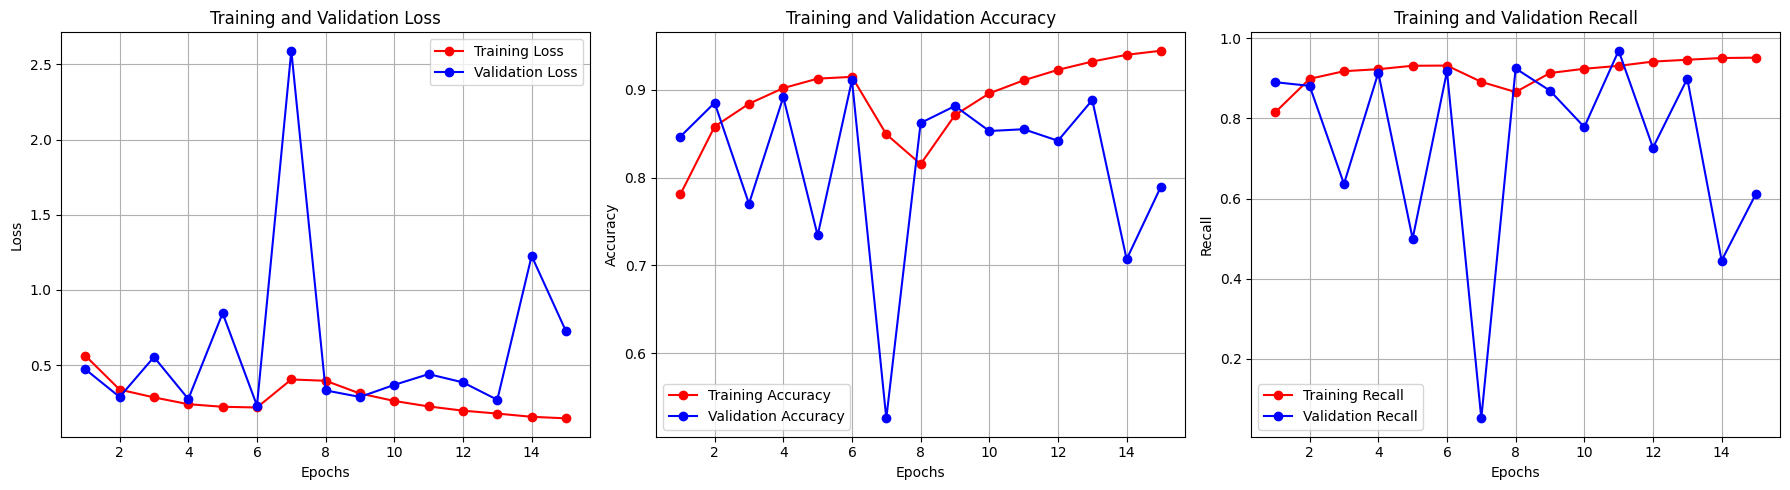

Best parameters: [0.0014578091067267067, 32, <class '__main__.BasicBlock'>, 5, 3, 6, 3]


In [48]:
# Run Bayesian optimization
results = gp_minimize(objective, dimensions, n_calls=10, random_state=0)

# Best hyperparameters
print("Best parameters: {}".format(results.x))


### ResNet Hyperparameter tuning results
There are two models that perfermed particularly well:
<br/><br/>
ResNet Model 1:
- 'learning_rate': 0.0014578091067267067
- 'batch_size': 32
- 'block_type': BasicBlock
- 'numblocks_1': 5
- 'numblocks_2': 3
- 'numblocks_3': 6
- 'numblocks_4': 3
By restoring the weights to the epoch with the lowest validation loss we get the least overfitting.
With these parameters, the lowest loss is at epoch 15, with a value of **0.1437**. Its correspondent validation accuracy is **95.03%** and the validation recall for class 1 (tumor) is **95.97%**.

However, the trend of the validation loss function of this model is not as smooth and downward as we would like it to be, as shown by the graphs below:

![ResNet Model 1](hyperparameter_results/ResNet_model_1.png)  
---------------------------------  
For these reason, let's consider another ResNet model, with the following set of parameters.  
<br/><br/>
ResNet Model 2:
- 'learning_rate': 0.00044678075533567343
- 'batch_size': 16
- 'block_type': Bottleneck
- 'numblocks_1': 8
- 'numblocks_2': 6
- 'numblocks_3': 5
- 'numblocks_4': 8  

With these parameters, the lowest loss is at epoch 14, with a value of **0.1687**. Its correspondent validation accuracy is **93.57%** and the validation recall for class 1 (tumor) is **94.58%**. Despite all these results appear slightly worse compared to the other ResNet Model, we can appreciate its much smoother ad downward trend of its validation loss. Such result shows no overfitting. Therefore, despite a very small decrease in accuracy and validation recall, this model should be preferred over the previous one. Moreover, its accuracy and validation recall just as good (well above 90%).  

![ResNet Model 1](hyperparameter_results/ResNet_model_2.png)  

### Conclusion hyperparameter tuning
In conclusion, the best model between the simpler CNN version and the ResNet one would be the **ResNet Model 2** (latest shown above).

### Model interpretability

In [ ]:
BATCH_SIZE = 16
torch.manual_seed(42)
train_dataset = PCAMDataset(images[train_indices], labels[train_indices], train=True)
val_dataset = PCAMDataset(images[val_indices], labels[val_indices], train=False)
train_dataloader = DataLoader(train_dataset, batch_size= int(BATCH_SIZE), shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=int(BATCH_SIZE), shuffle=False)

net_args = {
    "block": BasicBlock,
    "layers": [8, 6, 5, 8],
    "num_classes": 2,} 

ResNet_model_2 = ResNet(**net_args).to(device)
# print(model)
num_epochs = 15
lr = 0.00044678075533567343
optimizer_ResNet_model_2 = torch.optim.AdamW(ResNet_model_2.parameters(), lr=lr)
_, _, _, _, _ = training_loop(ResNet_model_2, num_epochs, train_dataloader, val_dataloader, optimizer_ResNet_model_2, criterion, device, plot_metrs = True)

In [52]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from torchvision import transforms

# Function to preprocess images
def preprocess(image):
    transform = transforms.Compose([transforms.ToTensor()])
    return transform(image).unsqueeze(0)

def batch_predict(images):
    ResNet_model_2.eval()
    batch = torch.stack(tuple(preprocess(i) for i in images), dim=0)

    # Reshape the batch to be the correct shape
    batch = batch.view(-1, 3, 96, 96)  # Assuming all images are of size 96x96 with 3 channels

    ResNet_model_2.to(device)
    batch = batch.to(device)
    
    with torch.no_grad():
        outputs = ResNet_model_2(batch)
        probs = F.softmax(outputs, dim=1)
        return probs.cpu().numpy()


# Initialize LIME for images
explainer = lime_image.LimeImageExplainer()

# Choose an image from the dataset
image_to_explain = images[40] # Load or select an image

# Segmenter algorithm to divide the image into superpixels
segmenter = SegmentationAlgorithm('slic', n_segments=100, compactness=1, sigma=1)

# Get the explanation
explanation = explainer.explain_instance(image_to_explain, 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000, # number of images to sample
                                         segmentation_fn=segmenter)

# Visualize the explanation
from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry1 = mark_boundaries(temp / 255.0, mask)



  0%|          | 0/1000 [00:00<?, ?it/s]

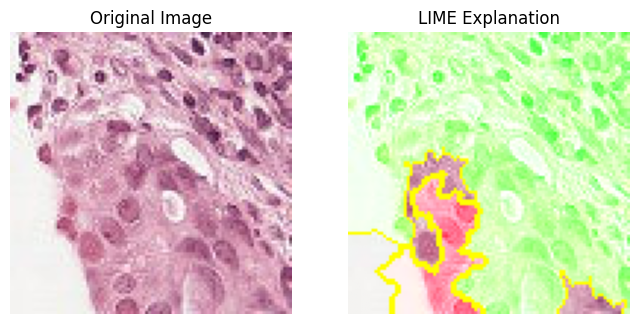

In [30]:
# Get image and mask from explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

# Display original image
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image_to_explain)  # Assuming image_to_explain is in a displayable format
plt.axis('off')

# Display image with LIME explanations
img_boundaries = mark_boundaries(temp / 255.0, mask)
plt.subplot(1, 2, 2)
plt.title('LIME Explanation')
plt.imshow(img_boundaries)
plt.axis('off')

plt.show()


**LIME Explanation:**

1. *Local Surrogate Model:* LIME works by perturbing the input data near the instance under scrutiny and monitoring how the model's predictions change. In the context of images, this involves dividing the image into "superpixels" and temporarily deactivating some of these superpixels (turning them gray) to observe alterations in the model's output.

2. *Interpretable Model:* LIME creates an interpretable model (such as a linear model) using this newly generated dataset of modified samples and their corresponding predictions from the opaque black-box model.

3. *Feature Importance:* The coefficients of the linear model reflect the significance of each superpixel in influencing the model's prediction. These coefficients are employed to construct an explanation map, highlighting superpixels with the most notable positive or negative impact on the prediction.

4. *Visualization:* The explanation map is superimposed onto the original image to provide a visual representation of the areas that carry the most weight in the model's prediction.

**Image above:**

- The green regions denote the superpixels that contribute positively to the model's prediction for the top predicted label. These areas strongly support the model's decision.

- Conversely, the red regions represent superpixels that adversely affect the top label's prediction, indicating that their presence reduces the model's confidence in that particular label.

- The outlined boundaries around the superpixels indicate the areas that LIME took into account when assessing the model's behavior.


(-0.5, 95.5, 95.5, -0.5)

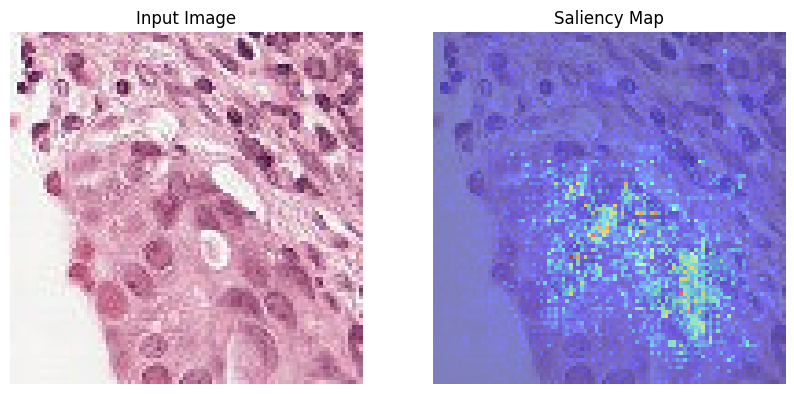

In [72]:
## Code block to use saliency maps

# Choose a particular image and corresponding label in which to investigate the classifications of the network
image = images[40]
label = labels[40]

preprocess = transforms.Compose([transforms.ToTensor()]) ### Here put the transforms to be applied

input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension
# Set the model to evaluation mode
ResNet_model_2.eval()

# Set the requires_grad attribute of the input tensor to True for gradients
input_tensor.requires_grad_(True)

# Forward pass to get the model prediction
output = ResNet_model_2(input_tensor.to(device))

# Choose the class index for which you want to visualize the saliency map
class_index = torch.argmax(output)

ResNet_model_2.zero_grad()

# Backward pass to get the gradients of the output w.r.t the input
output[0, class_index].backward()

# Get the gradients from the input tensor
saliency_map = input_tensor.grad.squeeze(0).abs().cpu().numpy()

# Normalize the saliency map for visualization (optional)
saliency_map = saliency_map / saliency_map.max()

normalized_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

# Convert the saliency map back to a uint8 image format (0-255)
saliency_map_image = np.uint8(255 * normalized_saliency_map)

# Aggregate across the channels
aggregate_saliency = saliency_map.sum(axis=0)

# Plot the input image and its corresponding saliency map side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the input image
axes[0].imshow(image)
axes[0].set_title('Input Image')
axes[0].axis('off')

# Plot the saliency map
axes[1].imshow(aggregate_saliency, cmap='jet', alpha=0.7)  # Overlay saliency map on the input image
axes[1].imshow(image, alpha=0.3)  # Overlay input image for comparison
axes[1].set_title('Saliency Map')
axes[1].axis('off')